# ML2 Imbalance AutoML Notebook

This reviewer is meant to supplement the Reader’s existing reviewers and notes. The author of this notebook shall not assume any responsibility on the accuracy and completeness of any information provided in this reviewer. The Reader is
expected to exercise prudence in reading through the reviewer and is free to comment on its accuracy and
completeness for everyone's benefit.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
%matplotlib inline

import time
from tqdm import tqdm
from pandas.api.types import is_numeric_dtype
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.neighbors import KNeighborsClassifier
from collections import Counter
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, recall_score, precision_score, average_precision_score, auc, f1_score
import shap

# not advisable, but we do it for a cleaner report
# warnings regarding non-convergence of some classifiers used are muted
import warnings 
warnings.filterwarnings("ignore")

# About the Data

Information about the Heart Disease UCI Dataset
---

- `age`: The person’s age in years

- `sex`: The person’s sex (1 = male, 0 = female)

- `cp`: chest pain type
   - Value 0: asymptomatic
   - Value 1: atypical angina
   - Value 2: non-anginal pain
   - Value 3: typical angina
    
- `trestbps`: The person’s resting blood pressure (mm Hg on admission to the hospital)

- `chol`: The person’s cholesterol measurement in mg/dl

- `fbs`: The person’s fasting blood sugar (> 120 mg/dl, 1 = true; 0 = false)

- `restecg`: resting electrocardiographic results
    - Value 0: showing probable or definite left ventricular hypertrophy by Estes’ criteria
    - Value 1: normal
    - Value 2: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)

- `thalach`: The person’s maximum heart rate achieved

- `exang`: Exercise induced angina (1 = yes; 0 = no)

- `oldpeak`: ST depression induced by exercise relative to rest (‘ST’ relates to positions on the ECG plot. See more here)

- `slope`: the slope of the peak exercise ST segment — 0: downsloping; 1: flat; 2: upsloping
    - 0: downsloping
    - 1: flat
    - 2: upsloping

- `ca`: The number of major vessels (0–3)

- `thal`: A blood disorder called thalassemia Value 0: NULL (dropped from the dataset previously
    - 1: fixed defect (no blood flow in some part of the heart)
    - 2: normal blood flow
    - 3: reversible defect (a blood flow is observed but it is not normal)

- `target`: Heart disease (1 = no, 0= yes)

In [2]:
# read dataset
df = pd.read_csv('heart.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


## Identify Numeric, Categoric, *Bag-of-Words* Columns/Features

|Column/Attribute Name| Data Type | Description |
| :--- | :--- | :---- |
| age | int | numeric |
| sex | int |categoric|
| cp |int | categoric |
| trestbps |int | numeric |
| chol | int| numeric |
| fbs | int | categoric |
| restecg | int| categoric |
| thalach | int| numeric |
| exang | int| categoric |
| oldpeak | float | numeric |
| slope | int| categoric |
| ca | int| numeric |
| thal | int| categoric |
| target | int| categoric |

# Data Pre-processing

In [3]:
# check for dtypes
df.dtypes

age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal          int64
target        int64
dtype: object

In [4]:
# change to appropriate dtypes
# always check for dtypes since pd.get_dummies will not one hot encode a column if it is numeric
# exclude target feature here

def change_dtype(df, col_dtype_change):
    for col in col_dtype_change:
        df[col] = df[col].astype('object')
    return df
    
col_dtype_change = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal'] # edit here
change_dtype(df, col_dtype_change).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    object 
 2   cp        303 non-null    object 
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    object 
 6   restecg   303 non-null    object 
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    object 
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    object 
 11  ca        303 non-null    int64  
 12  thal      303 non-null    object 
 13  target    303 non-null    int64  
dtypes: float64(1), int64(6), object(7)
memory usage: 33.3+ KB


In [5]:
# check for missing values
df.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [6]:
# if missing values are present
# instantiate class for imputation

class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with mean of column.

        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

In [7]:
# code snippet for simple imputation

df_clean = DataFrameImputer().fit_transform(df)
df_clean.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [8]:
# check dtypes of df_clean
# there is a need to check the dtypes of the columns of the imputed dataframe since
# the data imputer usually converts the column into numeric dtypes
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [9]:
# change dtype of df_clean and change categoric columns into object dtypes
# for a new dataframe, just edit the list below according to the column names of the data which are categoric in nature
col_dtype_change = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']
change_dtype(df_clean, col_dtype_change).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    object 
 2   cp        303 non-null    object 
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    object 
 6   restecg   303 non-null    object 
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    object 
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    object 
 11  ca        303 non-null    int64  
 12  thal      303 non-null    object 
 13  target    303 non-null    int64  
dtypes: float64(1), int64(6), object(7)
memory usage: 33.3+ KB


In [10]:
# get target feature
def get_target_col(df_clean, target_col_name):
    return df_clean[target_col_name]

# sample
target_col_name = 'target' # edit here
df_target = get_target_col(df_clean, 'target')
df_target

0      1
1      1
2      1
3      1
4      1
      ..
298    0
299    0
300    0
301    0
302    0
Name: target, Length: 303, dtype: int64

In [11]:
def drop_target_col(df_clean, target_col_name):
    df_clean.drop(target_col_name, axis=1, inplace=True) 
    return df_clean.info()

drop_target_col(df_clean, 'target')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    object 
 2   cp        303 non-null    object 
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    object 
 6   restecg   303 non-null    object 
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    object 
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    object 
 11  ca        303 non-null    int64  
 12  thal      303 non-null    object 
dtypes: float64(1), int64(5), object(7)
memory usage: 30.9+ KB


In [12]:
# get numeric columns
# note that the numeric columns had been separated for easier input to EDA code snippets
def get_numeric(df_clean):
    df_num = pd.DataFrame()
    for col in df_clean.columns:
        if is_numeric_dtype(df_clean[col]):
            df_num = pd.concat([df_num, df_clean[col]], axis=1)
    return df_num

df_num = get_numeric(df_clean)
df_num.info()

<class 'pandas.core.frame.DataFrame'>
Index: 303 entries, 0 to 302
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   trestbps  303 non-null    int64  
 2   chol      303 non-null    int64  
 3   thalach   303 non-null    int64  
 4   oldpeak   303 non-null    float64
 5   ca        303 non-null    int64  
dtypes: float64(1), int64(5)
memory usage: 16.6+ KB


In [13]:
# get categorical columns
# this function automatically one hot ecnodes the categorical features provided that they are the correct dtypes
# note that the categoric columns had been separated for easier input to EDA code snippets
def get_categorical(df_clean):
    df_cat_2 = pd.DataFrame()
    df_cat_3 = pd.DataFrame()
    for col in df_clean.columns:
        if is_numeric_dtype(df_clean[col]) == False:
            if df_clean[col].nunique() == 2:
                df_cat_2 = pd.concat([df_cat_2, df_clean[col]], axis=1)
            elif df_clean[col].nunique() > 2:
                df_cat_3 = pd.concat([df_cat_3, df_clean[col]], axis=1)
    df_cat_2_ohe = pd.get_dummies(df_cat_2, drop_first=True)
    df_cat_3_ohe = pd.get_dummies(df_cat_3)
    df_cat = pd.concat([df_cat_2_ohe, df_cat_3_ohe], axis=1)
    return df_cat

df_cat = get_categorical(df_clean)
df_cat

,sex_1,fbs_1,exang_1,cp_0,cp_1,cp_2,cp_3,restecg_0,restecg_1,restecg_2,slope_0,slope_1,slope_2,thal_0,thal_1,thal_2,thal_3
0,1,1,0,0,0,0,1,1,0,0,1,0,0,0,1,0,0
1,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0
2,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0
3,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0
4,0,0,1,1,0,0,0,0,1,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,1
299,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1
300,1,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1
301,1,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,1


In [14]:
# get final feature dataframe
def get_feature(df_num, df_cat):
    return pd.concat([df_num, df_cat], axis=1)
df_feature = get_feature(df_num, df_cat)
df_feature

,age,trestbps,chol,thalach,oldpeak,ca,sex_1,fbs_1,exang_1,cp_0,...,restecg_0,restecg_1,restecg_2,slope_0,slope_1,slope_2,thal_0,thal_1,thal_2,thal_3
0,63,145,233,150,2.3,0,1,1,0,0,...,1,0,0,1,0,0,0,1,0,0
1,37,130,250,187,3.5,0,1,0,0,0,...,0,1,0,1,0,0,0,0,1,0
2,41,130,204,172,1.4,0,0,0,0,0,...,1,0,0,0,0,1,0,0,1,0
3,56,120,236,178,0.8,0,1,0,0,0,...,0,1,0,0,0,1,0,0,1,0
4,57,120,354,163,0.6,0,0,0,1,1,...,0,1,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,140,241,123,0.2,0,0,0,1,1,...,0,1,0,0,1,0,0,0,0,1
299,45,110,264,132,1.2,0,1,0,0,0,...,0,1,0,0,1,0,0,0,0,1
300,68,144,193,141,3.4,2,1,1,0,1,...,0,1,0,0,1,0,0,0,0,1
301,57,130,131,115,1.2,1,1,0,1,1,...,0,1,0,0,1,0,0,0,0,1


# Exploratory Data Analysis

The functions created here are plug-in play provided that the proper arguments have been inputted. The arguments have been named intuitively for the benefit of the user. Apologies in advance if documentation have not been included. No time to do docs :(.

In [15]:
# get clean dataframe for EDA
def get_df_eda(df_clean, df_target):
    return pd.concat([df_clean, df_target], axis=1)

df_eda = get_df_eda(df_clean, df_target)
df_eda

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


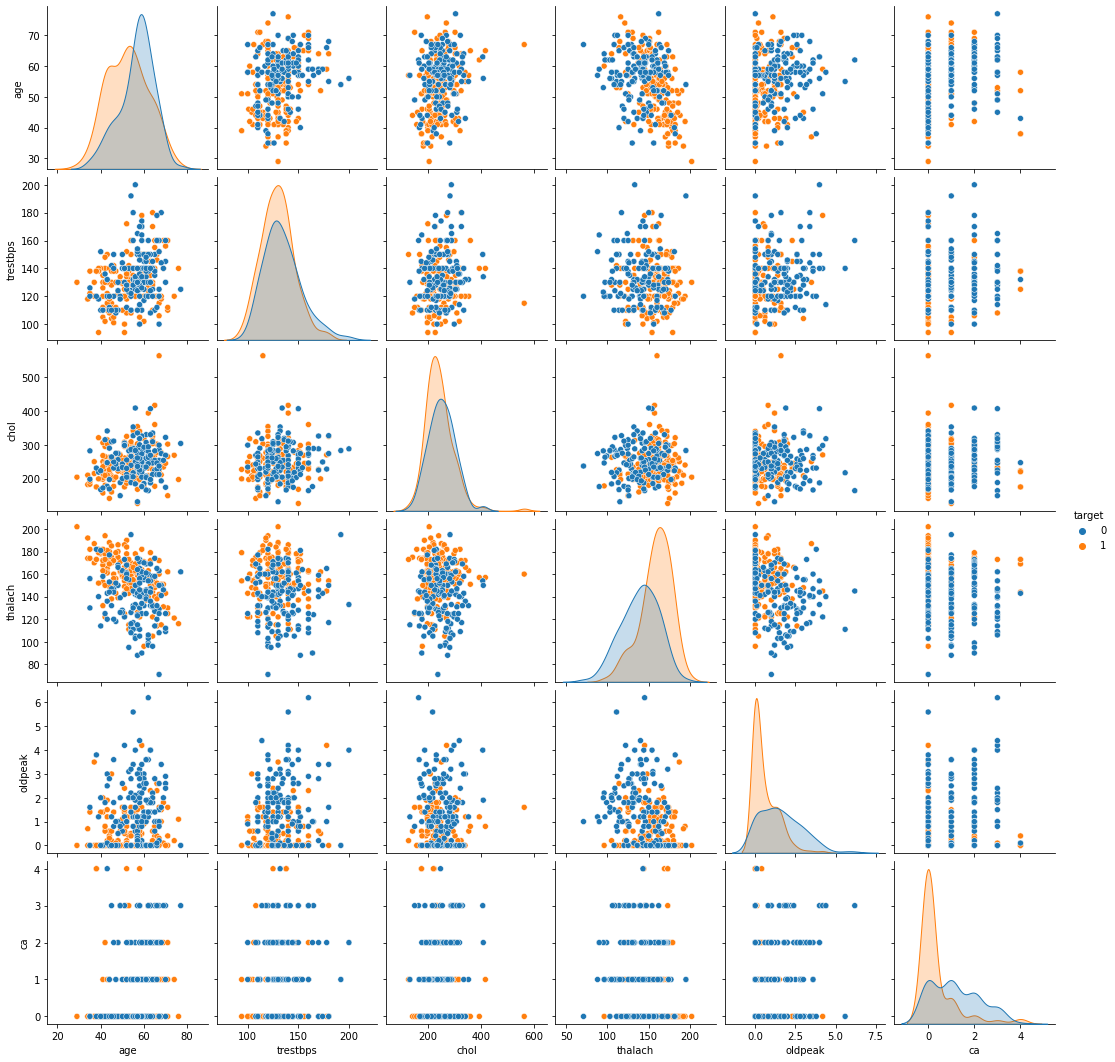

In [16]:
# code snippet for pairplot
# sns pairplot returns an error if part of dataframe are not numerical columns
# this code automatically looks for the numerical columns and plots them in the pairplot
def get_pairplot(df_eda, target_column):
    df_num = pd.DataFrame()
    for col in df_clean.columns:
        if is_numeric_dtype(df_clean[col]):
            df_num = pd.concat([df_num, df_clean[col]], axis=1)
    df_num = pd.concat([df_num, df_target], axis=1)
    return sns.pairplot(df_num, hue=target_column)

get_pairplot(df_eda, 'target')

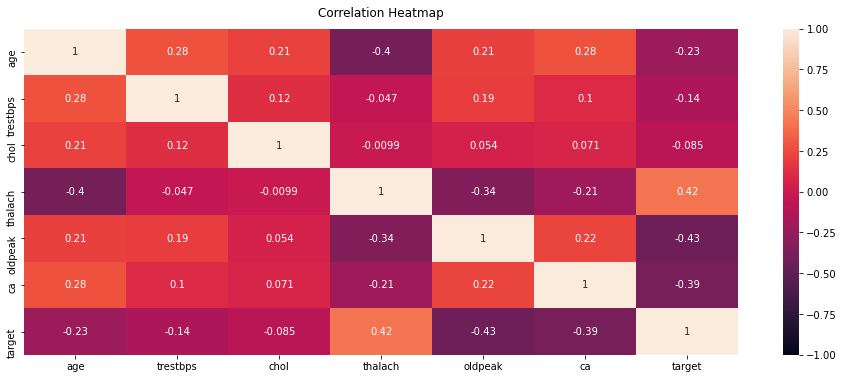

In [17]:
# code snippet for correlation matrix
def get_corr_matrix(df_eda, figsize):
    
    # Increase the size of the heatmap.
    plt.figure(figsize=figsize)

    # Store heatmap object in a variable to easily access it when you want to include more features (such as title).
    # Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
    heatmap = sns.heatmap(df_eda.corr(), vmin=-1, vmax=1, annot=True)

    # Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
    heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

get_corr_matrix(df_eda, (16,6))

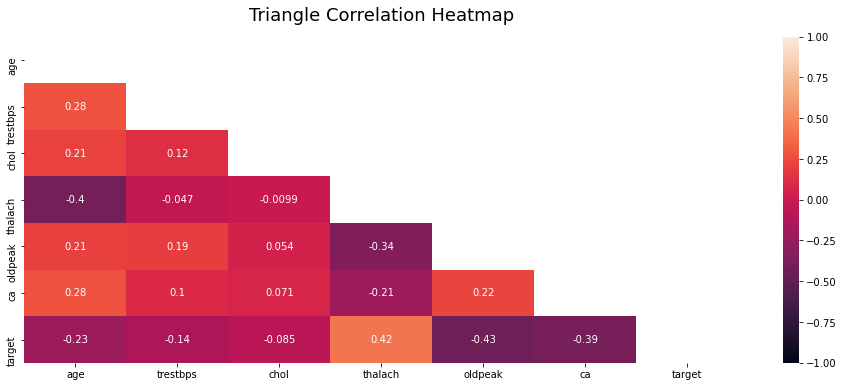

In [18]:
# code snippet for triangle correlation heatmap

def get_tri_corr_matrix(df_eda, figsize):
    
    plt.figure(figsize=figsize)
    # define the mask to set the values in the upper triangle to True

    mask = np.triu(np.ones_like(df_eda.corr(), dtype=np.bool))
    heatmap = sns.heatmap(df_eda.corr(), mask=mask, vmin=-1, vmax=1, annot=True)
    heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

get_tri_corr_matrix(df_eda, (16,6))

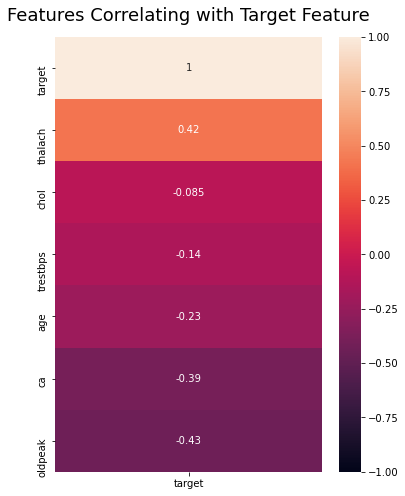

In [19]:
# code snippet for getting correlations of features to target variable
def get_corr_for_target_feature(df_eda, figsize, target_column, title=None):

    plt.figure(figsize=figsize)
    heatmap = sns.heatmap(df_eda.corr()[[target_column]].sort_values(by=target_column, ascending=False), vmin=-1, vmax=1, annot=True)
    heatmap.set_title(title, fontdict={'fontsize':18}, pad=16);

get_corr_for_target_feature(df_eda, (6,8), 'target', title='Features Correlating with Target Feature')

In [20]:
# describe numerical data
df_eda.describe()

,age,trestbps,chol,thalach,oldpeak,ca,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,131.623762,246.264026,149.646865,1.039604,0.729373,0.544554
std,9.082101,17.538143,51.830751,22.905161,1.161075,1.022606,0.498835
min,29.000000,94.000000,126.000000,71.000000,0.000000,0.000000,0.000000
25%,47.500000,120.000000,211.000000,133.500000,0.000000,0.000000,0.000000
50%,55.000000,130.000000,240.000000,153.000000,0.800000,0.000000,1.000000
75%,61.000000,140.000000,274.500000,166.000000,1.600000,1.000000,1.000000
max,77.000000,200.000000,564.000000,202.000000,6.200000,4.000000,1.000000


In [21]:
# describe categorical data
df_eda.describe(include='object')

,sex,cp,fbs,restecg,exang,slope,thal
count,303,303,303,303,303,303,303
unique,2,4,2,3,2,3,4
top,1,0,0,1,0,2,2
freq,207,143,258,152,204,142,166


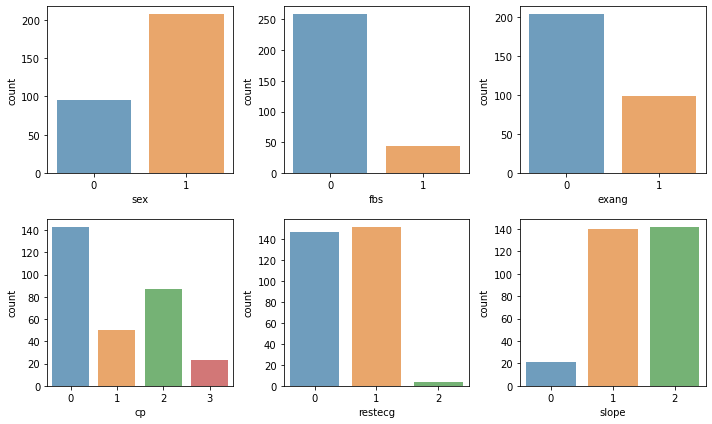

In [22]:
# plot categorical data
# this function automatically plots the categorical columns in accordance to frequency
def get_count_plot_categoric(df_clean, rotation, figsize):
    df_cat_2 = pd.DataFrame()
    df_cat_3 = pd.DataFrame()
    for col in df_clean.columns:
        if is_numeric_dtype(df_clean[col]) == False:
            if df_clean[col].nunique() == 2:
                df_cat_2 = pd.concat([df_cat_2, df_clean[col]], axis=1)
            elif df_clean[col].nunique() > 2:
                df_cat_3 = pd.concat([df_cat_3, df_clean[col]], axis=1)
    df_cat_eda = pd.concat([df_cat_2, df_cat_3], axis=1)

    fig, axes = plt.subplots(round(len(df_cat_eda.columns) / 3), 3, figsize=figsize)

    for i, ax in enumerate(fig.axes):
        if i < len(df_cat_eda.columns):
            ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=rotation)
            sns.countplot(x=df_cat_eda.columns[i], alpha=0.7, data=df_cat_eda, ax=ax)

    fig.tight_layout()

get_count_plot_categoric(df_eda, None, (10,6))

# Machine Learning Training and Validation

## Classification

### PCC

Population per class:     0
1  165
0  138
Proportion Chance Criterion: 50.40%
1.25 * Proportion Chance Criterion: 63.00%


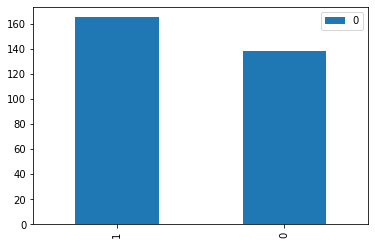

In [23]:
# this is the code snippet for the PCC
# just edit the target_count if your dataframe is not named as df_target
target_count = Counter(df_target) # edit here
df_pcc = pd.DataFrame.from_dict(target_count, orient='index')
df_pcc.plot(kind='bar')

num=(df_pcc[0]/df_pcc[0].sum())**2

print("Population per class:{}".format(df_pcc))

print("Proportion Chance Criterion: {:0.2f}%".format(100*num.sum()))
print("1.25 * Proportion Chance Criterion: {:0.2f}%".format(1.25*100*num.sum()))

### Visualize Distribution of Data Using Dimensionality Reduction

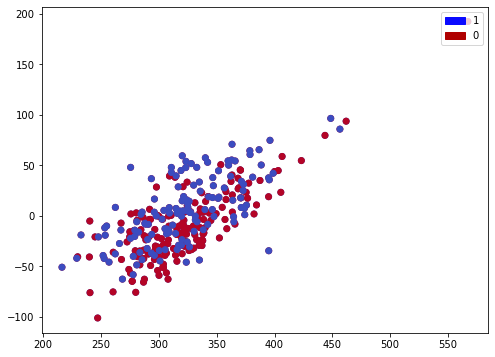

In [24]:
# implement dimensionality reduction to visualize the distribution of target

# apply truncated SVD
tsvd = TruncatedSVD(n_components=2, n_iter=7, random_state=45)
tsvd.fit(df_feature)

# put reduced data in a dataframe
df_feature_reduced = tsvd.fit_transform(df_feature)

# plot
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

blue_patch = mpatches.Patch(color='#0A0AFF', label='1')
red_patch = mpatches.Patch(color='#AF0000', label='0')

ax.scatter(df_feature_reduced[:,0], df_feature_reduced[:,1], c=(df_target==0), cmap='coolwarm', label='0')
ax.scatter(df_feature_reduced[:,0], df_feature_reduced[:,1], c=(df_target==1), cmap='coolwarm', label='1')
ax.legend(handles=[blue_patch, red_patch], loc="upper right")
plt.show()

### Train Test Split

In [25]:
# initialize inputs: trainval and holdout set, use stratify=y, test_size=0.25

X, y = df_feature, df_target # edit here

# scale data using standard scaler
# scaler = StandardScaler()
# X_scaled = pd.DataFrame(scaler.fit_transform(X))

(X_trainval, X_holdout, y_trainval, y_holdout) = train_test_split(X, y, # edit X here to include X_scaled in base case
                                           random_state=11, test_size=0.25, 
                                           stratify=y) # default

The succeeding cells contain code snippets for pipeline implementation. `kNN`, `Logistic Regression`, `LinearSVM`, `RBF SVM`, `Decision Trees`, `Random Forest`, `GBM`, and `GaussNB` are the models implemented here. Note that these models are for **CLASSIFICATION** and not for regression. The succeeding cells build up into a function at the last part wherein the user can just automatically call the function to perform implement the necessary machine learning models for training imbalance datasets. Hopefully, the succeeding cells provide an idea to the user on how to structure a pipeline inclusive of scaling and resampling techniques. Apologies in advance. No time to create notebook for regression problem :(.

### Base Case (No Tuning)

In [26]:
# kNN (Base Case)
pipeline_kNN = Pipeline([
        ('scale', StandardScaler()), # remove scaler if not needed
        ('kNN', KNeighborsClassifier())]) #######

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=11) # trainval splitting

# refer to this website for the list of metrics: https://scikit-learn.org/stable/modules/model_evaluation.html

scoring = ['accuracy', 'precision', 'recall', 'f1', 'average_precision']

cv_scores_kNN = cross_validate(estimator=pipeline_kNN, X=X_trainval, y=y_trainval,
                            scoring=scoring, cv=skf, n_jobs=-1, return_train_score=True)

# train scores
train_acc_kNN = round(np.mean(cv_scores_kNN['train_accuracy'])*100, 2)
train_prec_kNN = round(np.mean(cv_scores_kNN['train_precision'])*100, 2)
train_rec_kNN = round(np.mean(cv_scores_kNN['train_recall'])*100, 2)
train_f1_kNN = round(np.mean(cv_scores_kNN['train_f1'])*100, 2)
train_auc_pr_kNN = round(np.mean(cv_scores_kNN['train_average_precision'])*100, 2)

# test scores
test_acc_kNN = round(np.mean(cv_scores_kNN['test_accuracy'])*100, 2)
test_prec_kNN = round(np.mean(cv_scores_kNN['test_precision'])*100, 2)
test_rec_kNN = round(np.mean(cv_scores_kNN['test_recall'])*100, 2)
test_f1_kNN = round(np.mean(cv_scores_kNN['test_f1'])*100, 2)
test_auc_pr_kNN = round(np.mean(cv_scores_kNN['test_average_precision'])*100, 2)

# fit and predict
pipeline_kNN.fit(X_trainval, y_trainval)
y_preds_kNN = pipeline_kNN.predict(X_holdout)

# holdout scores
holdout_acc_kNN = round(accuracy_score(y_holdout, y_preds_kNN)*100, 2)
holdout_prec_kNN = round(precision_score(y_holdout, y_preds_kNN, pos_label=1)*100, 2)
holdout_rec_kNN = round(recall_score(y_holdout, y_preds_kNN, pos_label=1)*100, 2)
holdout_f1_kNN = round(f1_score(y_holdout, y_preds_kNN, pos_label=1)*100, 2)
holdout_auc_pr_kNN = round(average_precision_score(y_holdout, y_preds_kNN)*100, 2)

# kNN total run time
total_time_kNN = np.sum(cv_scores_kNN['fit_time']) + np.sum(cv_scores_kNN['score_time'])
kNN_time = total_time_kNN

df_kNN = pd.DataFrame(
{
    'train_acc': [train_acc_kNN],
    'test_acc': [test_acc_kNN],
    'holdout_acc': [holdout_acc_kNN],
    'train_prec': [train_prec_kNN],
    'test_prec': [test_prec_kNN],
    'holdout_prec': [holdout_prec_kNN],
    'train_rec': [train_rec_kNN],
    'test_rec': [test_rec_kNN],
    'holdout_rec': [holdout_rec_kNN],
    'train_f1': [train_f1_kNN],
    'test_f1': [test_f1_kNN],
    'holdout_f1': [holdout_f1_kNN],
    'train_auc_pr': [train_auc_pr_kNN],
    'test_auc_pr': [test_auc_pr_kNN],
    'holdout_auc_pr': [holdout_auc_pr_kNN],
    'total_run_time': [total_time_kNN]
}, index=['kNN'])

In [27]:
# Logistic Regression (Base Case)
pipeline_LR = Pipeline([
        ('scale', StandardScaler()), # remove scaler if not needed
        ('LR', LogisticRegression())])

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=11) # trainval splitting

# refer to this website for the list of metrics: https://scikit-learn.org/stable/modules/model_evaluation.html

scoring = ['accuracy', 'precision', 'recall', 'f1', 'average_precision']

cv_scores_LR = cross_validate(estimator=pipeline_LR, X=X_trainval, y=y_trainval,
                            scoring=scoring, cv=skf, n_jobs=-1, return_train_score=True)

# train scores
train_acc_LR = round(np.mean(cv_scores_LR['train_accuracy'])*100, 2)
train_prec_LR = round(np.mean(cv_scores_LR['train_precision'])*100, 2)
train_rec_LR = round(np.mean(cv_scores_LR['train_recall'])*100, 2)
train_f1_LR = round(np.mean(cv_scores_LR['train_f1'])*100, 2)
train_auc_pr_LR = round(np.mean(cv_scores_LR['train_average_precision'])*100, 2)

# test scores
test_acc_LR = round(np.mean(cv_scores_LR['test_accuracy'])*100, 2)
test_prec_LR = round(np.mean(cv_scores_LR['test_precision'])*100, 2)
test_rec_LR = round(np.mean(cv_scores_LR['test_recall'])*100, 2)
test_f1_LR = round(np.mean(cv_scores_LR['test_f1'])*100, 2)
test_auc_pr_LR = round(np.mean(cv_scores_LR['test_average_precision'])*100, 2)

# fit and predict
pipeline_LR.fit(X_trainval, y_trainval)
y_preds_LR = pipeline_LR.predict(X_holdout)

# holdout scores
holdout_acc_LR = round(accuracy_score(y_holdout, y_preds_LR)*100, 2)
holdout_prec_LR = round(precision_score(y_holdout, y_preds_LR, pos_label=1)*100, 2)
holdout_rec_LR = round(recall_score(y_holdout, y_preds_LR, pos_label=1)*100, 2)
holdout_f1_LR = round(f1_score(y_holdout, y_preds_LR, pos_label=1)*100, 2)
holdout_auc_pr_LR = round(average_precision_score(y_holdout, y_preds_LR)*100, 2)

# LR total run time
total_time_LR = np.sum(cv_scores_LR['fit_time']) + np.sum(cv_scores_LR['score_time'])
LR_time = total_time_LR

df_LR = pd.DataFrame(
{
    'train_acc': [train_acc_LR],
    'test_acc': [test_acc_LR],
    'holdout_acc': [holdout_acc_LR],
    'train_prec': [train_prec_LR],
    'test_prec': [test_prec_LR],
    'holdout_prec': [holdout_prec_LR],
    'train_rec': [train_rec_LR],
    'test_rec': [test_rec_LR],
    'holdout_rec': [holdout_rec_LR],
    'train_f1': [train_f1_LR],
    'test_f1': [test_f1_LR],
    'holdout_f1': [holdout_f1_LR],
    'train_auc_pr': [train_auc_pr_LR],
    'test_auc_pr': [test_auc_pr_LR],
    'holdout_auc_pr': [holdout_auc_pr_LR],
    'total_run_time': [total_time_LR]
}, index=['LR'])

In [28]:
# LinearSVM (Base Case)
pipeline_LSVM = Pipeline([
        ('scale', StandardScaler()), # remove scaler if not needed
        ('LSVM', SVC(kernel='linear'))])

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=11) # trainval splitting

# refer to this website for the list of metrics: https://scikit-learn.org/stable/modules/model_evaluation.html

scoring = ['accuracy', 'precision', 'recall', 'f1', 'average_precision']

cv_scores_LSVM = cross_validate(estimator=pipeline_LSVM, X=X_trainval, y=y_trainval,
                            scoring=scoring, cv=skf, n_jobs=-1, return_train_score=True)

# train scores
train_acc_LSVM = round(np.mean(cv_scores_LSVM['train_accuracy'])*100, 2)
train_prec_LSVM = round(np.mean(cv_scores_LSVM['train_precision'])*100, 2)
train_rec_LSVM = round(np.mean(cv_scores_LSVM['train_recall'])*100, 2)
train_f1_LSVM = round(np.mean(cv_scores_LSVM['train_f1'])*100, 2)
train_auc_pr_LSVM = round(np.mean(cv_scores_LSVM['train_average_precision'])*100, 2)

# test scores
test_acc_LSVM = round(np.mean(cv_scores_LSVM['test_accuracy'])*100, 2)
test_prec_LSVM = round(np.mean(cv_scores_LSVM['test_precision'])*100, 2)
test_rec_LSVM = round(np.mean(cv_scores_LSVM['test_recall'])*100, 2)
test_f1_LSVM = round(np.mean(cv_scores_LSVM['test_f1'])*100, 2)
test_auc_pr_LSVM = round(np.mean(cv_scores_LSVM['test_average_precision'])*100, 2)

# fit and predict
pipeline_LSVM.fit(X_trainval, y_trainval)
y_preds_LSVM = pipeline_LSVM.predict(X_holdout)

# holdout scores
holdout_acc_LSVM = round(accuracy_score(y_holdout, y_preds_LSVM)*100, 2)
holdout_prec_LSVM = round(precision_score(y_holdout, y_preds_LSVM, pos_label=1)*100, 2)
holdout_rec_LSVM = round(recall_score(y_holdout, y_preds_LSVM, pos_label=1)*100, 2)
holdout_f1_LSVM = round(f1_score(y_holdout, y_preds_LSVM, pos_label=1)*100, 2)
holdout_auc_pr_LSVM = round(average_precision_score(y_holdout, y_preds_LSVM)*100, 2)

# LSVM total run time
total_time_LSVM = np.sum(cv_scores_LSVM['fit_time']) + np.sum(cv_scores_LSVM['score_time'])
LSVM_time = total_time_LSVM

df_LSVM = pd.DataFrame(
{
    'train_acc': [train_acc_LSVM],
    'test_acc': [test_acc_LSVM],
    'holdout_acc': [holdout_acc_LSVM],
    'train_prec': [train_prec_LSVM],
    'test_prec': [test_prec_LSVM],
    'holdout_prec': [holdout_prec_LSVM],
    'train_rec': [train_rec_LSVM],
    'test_rec': [test_rec_LSVM],
    'holdout_rec': [holdout_rec_LSVM],
    'train_f1': [train_f1_LSVM],
    'test_f1': [test_f1_LSVM],
    'holdout_f1': [holdout_f1_LSVM],
    'train_auc_pr': [train_auc_pr_LSVM],
    'test_auc_pr': [test_auc_pr_LSVM],
    'holdout_auc_pr': [holdout_auc_pr_LSVM],
    'total_run_time': [total_time_LSVM]
}, index=['LSVM'])

In [29]:
# RBFSVM (Base Case)
pipeline_RBFSVM = Pipeline([
        ('scale', StandardScaler()), # remove scaler if not needed
        ('RBFSVM', SVC(kernel='rbf'))])

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=11) # trainval splitting

# refer to this website for the list of metrics: https://scikit-learn.org/stable/modules/model_evaluation.html

scoring = ['accuracy', 'precision', 'recall', 'f1', 'average_precision']

cv_scores_RBFSVM = cross_validate(estimator=pipeline_RBFSVM, X=X_trainval, y=y_trainval,
                            scoring=scoring, cv=skf, n_jobs=-1, return_train_score=True)

# train scores
train_acc_RBFSVM = round(np.mean(cv_scores_RBFSVM['train_accuracy'])*100, 2)
train_prec_RBFSVM = round(np.mean(cv_scores_RBFSVM['train_precision'])*100, 2)
train_rec_RBFSVM = round(np.mean(cv_scores_RBFSVM['train_recall'])*100, 2)
train_f1_RBFSVM = round(np.mean(cv_scores_RBFSVM['train_f1'])*100, 2)
train_auc_pr_RBFSVM = round(np.mean(cv_scores_RBFSVM['train_average_precision'])*100, 2)

# test scores
test_acc_RBFSVM = round(np.mean(cv_scores_RBFSVM['test_accuracy'])*100, 2)
test_prec_RBFSVM = round(np.mean(cv_scores_RBFSVM['test_precision'])*100, 2)
test_rec_RBFSVM = round(np.mean(cv_scores_RBFSVM['test_recall'])*100, 2)
test_f1_RBFSVM = round(np.mean(cv_scores_RBFSVM['test_f1'])*100, 2)
test_auc_pr_RBFSVM = round(np.mean(cv_scores_RBFSVM['test_average_precision'])*100, 2)

# fit and predict
pipeline_RBFSVM.fit(X_trainval, y_trainval)
y_preds_RBFSVM = pipeline_RBFSVM.predict(X_holdout)

# holdout scores
holdout_acc_RBFSVM = round(accuracy_score(y_holdout, y_preds_RBFSVM)*100, 2)
holdout_prec_RBFSVM = round(precision_score(y_holdout, y_preds_RBFSVM, pos_label=1)*100, 2)
holdout_rec_RBFSVM = round(recall_score(y_holdout, y_preds_RBFSVM, pos_label=1)*100, 2)
holdout_f1_RBFSVM = round(f1_score(y_holdout, y_preds_RBFSVM, pos_label=1)*100, 2)
holdout_auc_pr_RBFSVM = round(average_precision_score(y_holdout, y_preds_RBFSVM)*100, 2)

# RBFSVM total run time
total_time_RBFSVM = np.sum(cv_scores_RBFSVM['fit_time']) + np.sum(cv_scores_RBFSVM['score_time'])
RBFSVM_time = total_time_RBFSVM

df_RBFSVM = pd.DataFrame(
{
    'train_acc': [train_acc_RBFSVM],
    'test_acc': [test_acc_RBFSVM],
    'holdout_acc': [holdout_acc_RBFSVM],
    'train_prec': [train_prec_RBFSVM],
    'test_prec': [test_prec_RBFSVM],
    'holdout_prec': [holdout_prec_RBFSVM],
    'train_rec': [train_rec_RBFSVM],
    'test_rec': [test_rec_RBFSVM],
    'holdout_rec': [holdout_rec_RBFSVM],
    'train_f1': [train_f1_RBFSVM],
    'test_f1': [test_f1_RBFSVM],
    'holdout_f1': [holdout_f1_RBFSVM],
    'train_auc_pr': [train_auc_pr_RBFSVM],
    'test_auc_pr': [test_auc_pr_RBFSVM],
    'holdout_auc_pr': [holdout_auc_pr_RBFSVM],
    'total_run_time': [total_time_RBFSVM]
}, index=['RBFSVM'])

In [30]:
# GaussNB (Base Case)
pipeline_GaussNB = Pipeline([
        ('scale', StandardScaler()), # remove scaler if not needed
        ('GaussNB', GaussianNB())])

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=11) # trainval splitting

# refer to this website for the list of metrics: https://scikit-learn.org/stable/modules/model_evaluation.html

scoring = ['accuracy', 'precision', 'recall', 'f1', 'average_precision']

cv_scores_GaussNB = cross_validate(estimator=pipeline_GaussNB, X=X_trainval, y=y_trainval,
                            scoring=scoring, cv=skf, n_jobs=-1, return_train_score=True)

# train scores
train_acc_GaussNB = round(np.mean(cv_scores_GaussNB['train_accuracy'])*100, 2)
train_prec_GaussNB = round(np.mean(cv_scores_GaussNB['train_precision'])*100, 2)
train_rec_GaussNB = round(np.mean(cv_scores_GaussNB['train_recall'])*100, 2)
train_f1_GaussNB = round(np.mean(cv_scores_GaussNB['train_f1'])*100, 2)
train_auc_pr_GaussNB = round(np.mean(cv_scores_GaussNB['train_average_precision'])*100, 2)

# test scores
test_acc_GaussNB = round(np.mean(cv_scores_GaussNB['test_accuracy'])*100, 2)
test_prec_GaussNB = round(np.mean(cv_scores_GaussNB['test_precision'])*100, 2)
test_rec_GaussNB = round(np.mean(cv_scores_GaussNB['test_recall'])*100, 2)
test_f1_GaussNB = round(np.mean(cv_scores_GaussNB['test_f1'])*100, 2)
test_auc_pr_GaussNB = round(np.mean(cv_scores_GaussNB['test_average_precision'])*100, 2)

# fit and predict
pipeline_GaussNB.fit(X_trainval, y_trainval)
y_preds_GaussNB = pipeline_GaussNB.predict(X_holdout)

# holdout scores
holdout_acc_GaussNB = round(accuracy_score(y_holdout, y_preds_GaussNB)*100, 2)
holdout_prec_GaussNB = round(precision_score(y_holdout, y_preds_GaussNB, pos_label=1)*100, 2)
holdout_rec_GaussNB = round(recall_score(y_holdout, y_preds_GaussNB, pos_label=1)*100, 2)
holdout_f1_GaussNB = round(f1_score(y_holdout, y_preds_GaussNB, pos_label=1)*100, 2)
holdout_auc_pr_GaussNB = round(average_precision_score(y_holdout, y_preds_GaussNB)*100, 2)

# GaussNB total run time
total_time_GaussNB = np.sum(cv_scores_GaussNB['fit_time']) + np.sum(cv_scores_GaussNB['score_time'])
GaussNB_time = total_time_GaussNB

df_GaussNB = pd.DataFrame(
{
    'train_acc': [train_acc_GaussNB],
    'test_acc': [test_acc_GaussNB],
    'holdout_acc': [holdout_acc_GaussNB],
    'train_prec': [train_prec_GaussNB],
    'test_prec': [test_prec_GaussNB],
    'holdout_prec': [holdout_prec_GaussNB],
    'train_rec': [train_rec_GaussNB],
    'test_rec': [test_rec_GaussNB],
    'holdout_rec': [holdout_rec_GaussNB],
    'train_f1': [train_f1_GaussNB],
    'test_f1': [test_f1_GaussNB],
    'holdout_f1': [holdout_f1_GaussNB],
    'train_auc_pr': [train_auc_pr_GaussNB],
    'test_auc_pr': [test_auc_pr_GaussNB],
    'holdout_auc_pr': [holdout_auc_pr_GaussNB],
    'total_run_time': [total_time_GaussNB]
}, index=['GaussNB'])

In [31]:
# Decision Trees (Base Case)
pipeline_DT = Pipeline([
        ('scale', StandardScaler()), # remove scaler if not needed
        ('DT', DecisionTreeClassifier(random_state=11))])

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=11) # trainval splitting

# refer to this website for the list of metrics: https://scikit-learn.org/stable/modules/model_evaluation.html

scoring = ['accuracy', 'precision', 'recall', 'f1', 'average_precision']

cv_scores_DT = cross_validate(estimator=pipeline_DT, X=X_trainval, y=y_trainval,
                            scoring=scoring, cv=skf, n_jobs=-1, return_train_score=True)

# train scores
train_acc_DT = round(np.mean(cv_scores_DT['train_accuracy'])*100, 2)
train_prec_DT = round(np.mean(cv_scores_DT['train_precision'])*100, 2)
train_rec_DT = round(np.mean(cv_scores_DT['train_recall'])*100, 2)
train_f1_DT = round(np.mean(cv_scores_DT['train_f1'])*100, 2)
train_auc_pr_DT = round(np.mean(cv_scores_DT['train_average_precision'])*100, 2)

# test scores
test_acc_DT = round(np.mean(cv_scores_DT['test_accuracy'])*100, 2)
test_prec_DT = round(np.mean(cv_scores_DT['test_precision'])*100, 2)
test_rec_DT = round(np.mean(cv_scores_DT['test_recall'])*100, 2)
test_f1_DT = round(np.mean(cv_scores_DT['test_f1'])*100, 2)
test_auc_pr_DT = round(np.mean(cv_scores_DT['test_average_precision'])*100, 2)

# fit and predict
pipeline_DT.fit(X_trainval, y_trainval)
y_preds_DT = pipeline_DT.predict(X_holdout)

# holdout scores
holdout_acc_DT = round(accuracy_score(y_holdout, y_preds_DT)*100, 2)
holdout_prec_DT = round(precision_score(y_holdout, y_preds_DT, pos_label=1)*100, 2)
holdout_rec_DT = round(recall_score(y_holdout, y_preds_DT, pos_label=1)*100, 2)
holdout_f1_DT = round(f1_score(y_holdout, y_preds_DT, pos_label=1)*100, 2)
holdout_auc_pr_DT = round(average_precision_score(y_holdout, y_preds_DT)*100, 2)

# DT total run time
total_time_DT = np.sum(cv_scores_DT['fit_time']) + np.sum(cv_scores_DT['score_time'])
DT_time = total_time_DT

df_DT = pd.DataFrame(
{
    'train_acc': [train_acc_DT],
    'test_acc': [test_acc_DT],
    'holdout_acc': [holdout_acc_DT],
    'train_prec': [train_prec_DT],
    'test_prec': [test_prec_DT],
    'holdout_prec': [holdout_prec_DT],
    'train_rec': [train_rec_DT],
    'test_rec': [test_rec_DT],
    'holdout_rec': [holdout_rec_DT],
    'train_f1': [train_f1_DT],
    'test_f1': [test_f1_DT],
    'holdout_f1': [holdout_f1_DT],
    'train_auc_pr': [train_auc_pr_DT],
    'test_auc_pr': [test_auc_pr_DT],
    'holdout_auc_pr': [holdout_auc_pr_DT],
    'total_run_time': [total_time_DT]
}, index=['DT'])

In [32]:
# Random Forest (Base Case)
pipeline_RF = Pipeline([
        ('scale', StandardScaler()), # remove scaler if not needed
        ('RF', RandomForestClassifier(random_state=11))])

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=11) # trainval splitting

# refer to this website for the list of metrics: https://scikit-learn.org/stable/modules/model_evaluation.html

scoring = ['accuracy', 'precision', 'recall', 'f1', 'average_precision']

cv_scores_RF = cross_validate(estimator=pipeline_RF, X=X_trainval, y=y_trainval,
                            scoring=scoring, cv=skf, n_jobs=-1, return_train_score=True)

# train scores
train_acc_RF = round(np.mean(cv_scores_RF['train_accuracy'])*100, 2)
train_prec_RF = round(np.mean(cv_scores_RF['train_precision'])*100, 2)
train_rec_RF = round(np.mean(cv_scores_RF['train_recall'])*100, 2)
train_f1_RF = round(np.mean(cv_scores_RF['train_f1'])*100, 2)
train_auc_pr_RF = round(np.mean(cv_scores_RF['train_average_precision'])*100, 2)

# test scores
test_acc_RF = round(np.mean(cv_scores_RF['test_accuracy'])*100, 2)
test_prec_RF = round(np.mean(cv_scores_RF['test_precision'])*100, 2)
test_rec_RF = round(np.mean(cv_scores_RF['test_recall'])*100, 2)
test_f1_RF = round(np.mean(cv_scores_RF['test_f1'])*100, 2)
test_auc_pr_RF = round(np.mean(cv_scores_RF['test_average_precision'])*100, 2)

# fit and predict
pipeline_RF.fit(X_trainval, y_trainval)
y_preds_RF = pipeline_RF.predict(X_holdout)

# holdout scores
holdout_acc_RF = round(accuracy_score(y_holdout, y_preds_RF)*100, 2)
holdout_prec_RF = round(precision_score(y_holdout, y_preds_RF, pos_label=1)*100, 2)
holdout_rec_RF = round(recall_score(y_holdout, y_preds_RF, pos_label=1)*100, 2)
holdout_f1_RF = round(f1_score(y_holdout, y_preds_RF, pos_label=1)*100, 2)
holdout_auc_pr_RF = round(average_precision_score(y_holdout, y_preds_RF)*100, 2)

# RF total run time
total_time_RF = np.sum(cv_scores_RF['fit_time']) + np.sum(cv_scores_RF['score_time'])
RF_time = total_time_RF

df_RF = pd.DataFrame(
{
    'train_acc': [train_acc_RF],
    'test_acc': [test_acc_RF],
    'holdout_acc': [holdout_acc_RF],
    'train_prec': [train_prec_RF],
    'test_prec': [test_prec_RF],
    'holdout_prec': [holdout_prec_RF],
    'train_rec': [train_rec_RF],
    'test_rec': [test_rec_RF],
    'holdout_rec': [holdout_rec_RF],
    'train_f1': [train_f1_RF],
    'test_f1': [test_f1_RF],
    'holdout_f1': [holdout_f1_RF],
    'train_auc_pr': [train_auc_pr_RF],
    'test_auc_pr': [test_auc_pr_RF],
    'holdout_auc_pr': [holdout_auc_pr_RF],
    'total_run_time': [total_time_RF]
}, index=['RF'])

In [33]:
# GBM (Base Case)
pipeline_GBM = Pipeline([
        ('scale', StandardScaler()), # remove scaler if not needed
        ('GBM', GradientBoostingClassifier(random_state=11))])

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=11) # trainval splitting

# refer to this website for the list of metrics: https://scikit-learn.org/stable/modules/model_evaluation.html

scoring = ['accuracy', 'precision', 'recall', 'f1', 'average_precision']

cv_scores_GBM = cross_validate(estimator=pipeline_GBM, X=X_trainval, y=y_trainval,
                            scoring=scoring, cv=skf, n_jobs=-1, return_train_score=True)

# train scores
train_acc_GBM = round(np.mean(cv_scores_GBM['train_accuracy'])*100, 2)
train_prec_GBM = round(np.mean(cv_scores_GBM['train_precision'])*100, 2)
train_rec_GBM = round(np.mean(cv_scores_GBM['train_recall'])*100, 2)
train_f1_GBM = round(np.mean(cv_scores_GBM['train_f1'])*100, 2)
train_auc_pr_GBM = round(np.mean(cv_scores_GBM['train_average_precision'])*100, 2)

# test scores
test_acc_GBM = round(np.mean(cv_scores_GBM['test_accuracy'])*100, 2)
test_prec_GBM = round(np.mean(cv_scores_GBM['test_precision'])*100, 2)
test_rec_GBM = round(np.mean(cv_scores_GBM['test_recall'])*100, 2)
test_f1_GBM = round(np.mean(cv_scores_GBM['test_f1'])*100, 2)
test_auc_pr_GBM = round(np.mean(cv_scores_GBM['test_average_precision'])*100, 2)

# fit and predict
pipeline_GBM.fit(X_trainval, y_trainval)
y_preds_GBM = pipeline_GBM.predict(X_holdout)

# holdout scores
holdout_acc_GBM = round(accuracy_score(y_holdout, y_preds_GBM)*100, 2)
holdout_prec_GBM = round(precision_score(y_holdout, y_preds_GBM, pos_label=1)*100, 2)
holdout_rec_GBM = round(recall_score(y_holdout, y_preds_GBM, pos_label=1)*100, 2)
holdout_f1_GBM = round(f1_score(y_holdout, y_preds_GBM, pos_label=1)*100, 2)
holdout_auc_pr_GBM = round(average_precision_score(y_holdout, y_preds_GBM)*100, 2)

# GBM total run time
total_time_GBM = np.sum(cv_scores_GBM['fit_time']) + np.sum(cv_scores_GBM['score_time'])
GBM_time = total_time_GBM

df_GBM = pd.DataFrame(
{
    'train_acc': [train_acc_GBM],
    'test_acc': [test_acc_GBM],
    'holdout_acc': [holdout_acc_GBM],
    'train_prec': [train_prec_GBM],
    'test_prec': [test_prec_GBM],
    'holdout_prec': [holdout_prec_GBM],
    'train_rec': [train_rec_GBM],
    'test_rec': [test_rec_GBM],
    'holdout_rec': [holdout_rec_GBM],
    'train_f1': [train_f1_GBM],
    'test_f1': [test_f1_GBM],
    'holdout_f1': [holdout_f1_GBM],
    'train_auc_pr': [train_auc_pr_GBM],
    'test_auc_pr': [test_auc_pr_GBM],
    'holdout_auc_pr': [holdout_auc_pr_GBM],
    'total_run_time': [total_time_GBM]
}, index=['GBM'])

### Base Case Train, Validation, Holdout Scores (No Tuning)

In [34]:
# overall summary
# just concat the ML dataframes to one data frame
# five scoring metrics have been used: accuracy, precision, recall, f1 score, auc-pr
df_base_case_scores = pd.concat([df_kNN, df_LR, df_LSVM, df_RBFSVM, df_GaussNB, df_DT, df_RF, df_GBM], axis=0)
df_base_case_scores

,train_acc,test_acc,holdout_acc,train_prec,test_prec,holdout_prec,train_rec,test_rec,holdout_rec,train_f1,test_f1,holdout_f1,train_auc_pr,test_auc_pr,holdout_auc_pr,total_run_time
kNN,85.24,78.03,81.58,87.72,82.14,88.57,84.89,75.93,75.61,86.26,78.49,81.58,93.03,86.47,80.13,0.058849
LR,85.79,83.30,82.89,84.70,82.68,79.17,90.33,88.77,92.68,87.42,85.42,85.39,94.17,90.44,77.32,0.065824
LSVM,85.80,82.43,84.21,83.83,81.09,79.59,91.74,89.57,95.12,87.60,84.95,86.67,93.44,89.90,78.34,0.067823
RBFSVM,92.95,79.77,85.53,91.08,79.84,82.61,96.57,84.73,92.68,93.74,82.09,87.36,96.70,89.59,80.51,0.056849
GaussNB,75.12,68.76,78.95,80.64,76.01,80.49,79.33,70.60,80.49,75.62,68.52,80.49,91.75,86.48,75.31,0.041887
DT,100.00,73.13,75.00,100.00,80.03,78.95,100.00,69.33,73.17,100.00,73.67,75.95,100.00,71.81,72.24,0.046871
RF,100.00,81.54,81.58,100.00,82.55,80.00,100.00,84.70,87.80,100.00,83.32,83.72,100.00,90.45,76.82,0.580454
GBM,99.89,80.21,76.32,99.80,83.91,74.47,100.00,80.63,85.37,99.90,81.82,79.55,100.00,89.86,71.47,0.288231


In [35]:
# dataframe for test holdout
# just filter the columns that you need and drop them for the desired metric
df_base_case_test_holdout = df_base_case_scores.drop(['train_acc', 'train_prec', 'train_rec', 'train_f1', 'train_auc_pr'], axis=1)
df_base_case_test_holdout

,test_acc,holdout_acc,test_prec,holdout_prec,test_rec,holdout_rec,test_f1,holdout_f1,test_auc_pr,holdout_auc_pr,total_run_time
kNN,78.03,81.58,82.14,88.57,75.93,75.61,78.49,81.58,86.47,80.13,0.058849
LR,83.30,82.89,82.68,79.17,88.77,92.68,85.42,85.39,90.44,77.32,0.065824
LSVM,82.43,84.21,81.09,79.59,89.57,95.12,84.95,86.67,89.90,78.34,0.067823
RBFSVM,79.77,85.53,79.84,82.61,84.73,92.68,82.09,87.36,89.59,80.51,0.056849
GaussNB,68.76,78.95,76.01,80.49,70.60,80.49,68.52,80.49,86.48,75.31,0.041887
DT,73.13,75.00,80.03,78.95,69.33,73.17,73.67,75.95,71.81,72.24,0.046871
RF,81.54,81.58,82.55,80.00,84.70,87.80,83.32,83.72,90.45,76.82,0.580454
GBM,80.21,76.32,83.91,74.47,80.63,85.37,81.82,79.55,89.86,71.47,0.288231


### Base Case Train, Validation, Holdout Scores (With Tuning)

`GridSearhCV` is technically capable of calculating multiple metrics but it will return an error since it will not know what metric to optimize due to the multiple input metrics. In this case, `GridSearhCV` will ask for the `refit` argument to be specified. So for the succeeding cells, only a single metric will be specified. For the convenience of the user, the user may edit the metric in the succeeding cell for the run of the succeeding cells. The user may also edit the tuning parameters in the succeeding cells as needed. The user may follow the syntax (i.e. by adding `__` between the assigned name of the ML model and the argument within the model to be implemented - `kNN__n_neighbors`).

#### Edit Metric Here

In [36]:
# refer to this website for the list of metrics: https://scikit-learn.org/stable/modules/model_evaluation.html

scoring = ['accuracy', 'precision', 'recall', 'f1', 'average_precision']

metric = scoring[2] # recall

In [37]:
# kNN (Tuned)
pipeline_kNN = Pipeline([
        ('scale', StandardScaler()), # remove scaler if not needed
        ('kNN', KNeighborsClassifier())])

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=11) # trainval splitting

param_grid_kNN = {'kNN__n_neighbors': range(0, 30)} ####

grid_search_kNN = GridSearchCV(estimator=pipeline_kNN, scoring=metric,
                               cv=skf, n_jobs=-1, return_train_score=True,
                               param_grid=param_grid_kNN)

# fit and predict
grid_search_kNN.fit(X_trainval, y_trainval)
y_preds_kNN = grid_search_kNN.predict(X_holdout)

# holdout scores
holdout_acc_kNN = round(accuracy_score(y_holdout, y_preds_kNN)*100, 2)
holdout_prec_kNN = round(precision_score(y_holdout, y_preds_kNN, pos_label=1)*100, 2)
holdout_rec_kNN = round(recall_score(y_holdout, y_preds_kNN, pos_label=1)*100, 2)
holdout_f1_kNN = round(f1_score(y_holdout, y_preds_kNN, pos_label=1)*100, 2)
holdout_auc_pr_kNN = round(average_precision_score(y_holdout, y_preds_kNN)*100, 2)

holdout_dict = {
    'accuracy': holdout_acc_kNN,
    'precision': holdout_prec_kNN,
    'recall': holdout_rec_kNN,
    'f1': holdout_f1_kNN,
    'average_precision': holdout_auc_pr_kNN
}

# kNN total run time
total_time_kNN = np.sum(grid_search_kNN.cv_results_['mean_fit_time']) + np.sum(grid_search_kNN.cv_results_['mean_score_time'])
kNN_time = total_time_kNN

df_kNN_tuned = pd.DataFrame(
{
    metric: [round(grid_search_kNN.best_score_*100, 2)],
    'holdout_score': [holdout_dict[metric]],
    'params': [grid_search_kNN.best_params_],
    'total_run_time': [total_time_kNN]
}, index=['kNN'])

In [38]:
# Logistic Regression (Tuned)
pipeline_LR = Pipeline([
        ('scale', StandardScaler()), # remove scaler if not needed
        ('LR', LogisticRegression())])

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=11) # trainval splitting

param_grid_LR = {'LR__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 500, 1000],
                 'LR__penalty' : ['l1', 'l2'],
                 'LR__solver' : ['liblinear']}

grid_search_LR = GridSearchCV(estimator=pipeline_LR, scoring=metric,
                               cv=skf, n_jobs=-1, return_train_score=True,
                               param_grid=param_grid_LR)

# fit and predict
grid_search_LR.fit(X_trainval, y_trainval)
y_preds_LR = grid_search_LR.predict(X_holdout)

# holdout scores
holdout_acc_LR = round(accuracy_score(y_holdout, y_preds_LR)*100, 2)
holdout_prec_LR = round(precision_score(y_holdout, y_preds_LR, pos_label=1)*100, 2)
holdout_rec_LR = round(recall_score(y_holdout, y_preds_LR, pos_label=1)*100, 2)
holdout_f1_LR = round(f1_score(y_holdout, y_preds_LR, pos_label=1)*100, 2)
holdout_auc_pr_LR = round(average_precision_score(y_holdout, y_preds_LR)*100, 2)

holdout_dict = {
    'accuracy': holdout_acc_LR,
    'precision': holdout_prec_LR,
    'recall': holdout_rec_LR,
    'f1': holdout_f1_LR,
    'average_precision': holdout_auc_pr_LR
}

# LR total run time
total_time_LR = np.sum(grid_search_LR.cv_results_['mean_fit_time']) + np.sum(grid_search_LR.cv_results_['mean_score_time'])
LR_time = total_time_LR

df_LR_tuned = pd.DataFrame(
{
    metric: [round(grid_search_LR.best_score_*100, 2)],
    'holdout_score': [holdout_dict[metric]],
    'params': [grid_search_LR.best_params_],
    'total_run_time': [total_time_LR]
}, index=['LR'])

In [39]:
# LSVM (Tuned)
pipeline_LSVM = Pipeline([
        ('scale', StandardScaler()), # remove scaler if not needed
        ('LSVM', SVC(kernel='linear'))])

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=11) # trainval splitting

param_grid_LSVM = {'LSVM__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 500, 1000]}

grid_search_LSVM = GridSearchCV(estimator=pipeline_LSVM, scoring=metric,
                               cv=skf, n_jobs=-1, return_train_score=True,
                               param_grid=param_grid_LSVM)

# fit and predict
grid_search_LSVM.fit(X_trainval, y_trainval)
y_preds_LSVM = grid_search_LSVM.predict(X_holdout)

# holdout scores
holdout_acc_LSVM = round(accuracy_score(y_holdout, y_preds_LSVM)*100, 2)
holdout_prec_LSVM = round(precision_score(y_holdout, y_preds_LSVM, pos_label=1)*100, 2)
holdout_rec_LSVM = round(recall_score(y_holdout, y_preds_LSVM, pos_label=1)*100, 2)
holdout_f1_LSVM = round(f1_score(y_holdout, y_preds_LSVM, pos_label=1)*100, 2)
holdout_auc_pr_LSVM = round(average_precision_score(y_holdout, y_preds_LSVM)*100, 2)

holdout_dict = {
    'accuracy': holdout_acc_LSVM,
    'precision': holdout_prec_LSVM,
    'recall': holdout_rec_LSVM,
    'f1': holdout_f1_LSVM,
    'average_precision': holdout_auc_pr_LSVM
}

# LSVM total run time
total_time_LSVM = np.sum(grid_search_LSVM.cv_results_['mean_fit_time']) + np.sum(grid_search_LSVM.cv_results_['mean_score_time'])
LSVM_time = total_time_LSVM

df_LSVM_tuned = pd.DataFrame(
{
    metric: [round(grid_search_LSVM.best_score_*100, 2)],
    'holdout_score': [holdout_dict[metric]],
    'params': [grid_search_LSVM.best_params_],
    'total_run_time': [total_time_LSVM]
}, index=['LSVM'])

In [40]:
# RBFSVM (Tuned)
pipeline_RBFSVM = Pipeline([
        ('scale', StandardScaler()), # remove scaler if not needed
        ('RBFSVM', SVC(kernel='rbf'))])

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=11) # trainval splitting

param_grid_RBFSVM = {'RBFSVM__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 500, 1000]}

grid_search_RBFSVM = GridSearchCV(estimator=pipeline_RBFSVM, scoring=metric,
                               cv=skf, n_jobs=-1, return_train_score=True,
                               param_grid=param_grid_RBFSVM)

# fit and predict
grid_search_RBFSVM.fit(X_trainval, y_trainval)
y_preds_RBFSVM = grid_search_RBFSVM.predict(X_holdout)

# holdout scores
holdout_acc_RBFSVM = round(accuracy_score(y_holdout, y_preds_RBFSVM)*100, 2)
holdout_prec_RBFSVM = round(precision_score(y_holdout, y_preds_RBFSVM, pos_label=1)*100, 2)
holdout_rec_RBFSVM = round(recall_score(y_holdout, y_preds_RBFSVM, pos_label=1)*100, 2)
holdout_f1_RBFSVM = round(f1_score(y_holdout, y_preds_RBFSVM, pos_label=1)*100, 2)
holdout_auc_pr_RBFSVM = round(average_precision_score(y_holdout, y_preds_RBFSVM)*100, 2)

holdout_dict = {
    'accuracy': holdout_acc_RBFSVM,
    'precision': holdout_prec_RBFSVM,
    'recall': holdout_rec_RBFSVM,
    'f1': holdout_f1_RBFSVM,
    'average_precision': holdout_auc_pr_RBFSVM
}

# RBFSVM total run time
total_time_RBFSVM = np.sum(grid_search_RBFSVM.cv_results_['mean_fit_time']) + np.sum(grid_search_RBFSVM.cv_results_['mean_score_time'])
RBFSVM_time = total_time_RBFSVM

df_RBFSVM_tuned = pd.DataFrame(
{
    metric: [round(grid_search_RBFSVM.best_score_*100, 2)],
    'holdout_score': [holdout_dict[metric]],
    'params': [grid_search_RBFSVM.best_params_],
    'total_run_time': [total_time_RBFSVM]
}, index=['RBFSVM'])

In [41]:
# GaussNB (Tuned)
pipeline_GaussNB = Pipeline([
        ('scale', StandardScaler()), # remove scaler if not needed
        ('GaussNB', GaussianNB())])

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=11) # trainval splitting

param_grid_GaussNB = {'GaussNB__var_smoothing': np.logspace(0,-9, num=100)}

grid_search_GaussNB = GridSearchCV(estimator=pipeline_GaussNB, scoring=metric,
                               cv=skf, n_jobs=-1, return_train_score=True,
                               param_grid=param_grid_GaussNB)

# fit and predict
grid_search_GaussNB.fit(X_trainval, y_trainval)
y_preds_GaussNB = grid_search_GaussNB.predict(X_holdout)

# holdout scores
holdout_acc_GaussNB = round(accuracy_score(y_holdout, y_preds_GaussNB)*100, 2)
holdout_prec_GaussNB = round(precision_score(y_holdout, y_preds_GaussNB, pos_label=1)*100, 2)
holdout_rec_GaussNB = round(recall_score(y_holdout, y_preds_GaussNB, pos_label=1)*100, 2)
holdout_f1_GaussNB = round(f1_score(y_holdout, y_preds_GaussNB, pos_label=1)*100, 2)
holdout_auc_pr_GaussNB = round(average_precision_score(y_holdout, y_preds_GaussNB)*100, 2)

holdout_dict = {
    'accuracy': holdout_acc_GaussNB,
    'precision': holdout_prec_GaussNB,
    'recall': holdout_rec_GaussNB,
    'f1': holdout_f1_GaussNB,
    'average_precision': holdout_auc_pr_GaussNB
}

# GaussNB total run time
total_time_GaussNB = np.sum(grid_search_GaussNB.cv_results_['mean_fit_time']) + np.sum(grid_search_GaussNB.cv_results_['mean_score_time'])
GaussNB_time = total_time_GaussNB

df_GaussNB_tuned = pd.DataFrame(
{
    metric: [round(grid_search_GaussNB.best_score_*100, 2)],
    'holdout_score': [holdout_dict[metric]],
    'params': [grid_search_GaussNB.best_params_],
    'total_run_time': [total_time_GaussNB]
}, index=['GaussNB'])

In [42]:
# DT (Tuned)
pipeline_DT = Pipeline([
        ('scale', StandardScaler()), # remove scaler if not needed
        ('DT', DecisionTreeClassifier(random_state=11))])

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=11) # trainval splitting

param_grid_DT = {'DT__max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10]}

grid_search_DT = GridSearchCV(estimator=pipeline_DT, scoring=metric,
                               cv=skf, n_jobs=-1, return_train_score=True,
                               param_grid=param_grid_DT)

# fit and predict
grid_search_DT.fit(X_trainval, y_trainval)
y_preds_DT = grid_search_DT.predict(X_holdout)

# holdout scores
holdout_acc_DT = round(accuracy_score(y_holdout, y_preds_DT)*100, 2)
holdout_prec_DT = round(precision_score(y_holdout, y_preds_DT, pos_label=1)*100, 2)
holdout_rec_DT = round(recall_score(y_holdout, y_preds_DT, pos_label=1)*100, 2)
holdout_f1_DT = round(f1_score(y_holdout, y_preds_DT, pos_label=1)*100, 2)
holdout_auc_pr_DT = round(average_precision_score(y_holdout, y_preds_DT)*100, 2)

holdout_dict = {
    'accuracy': holdout_acc_DT,
    'precision': holdout_prec_DT,
    'recall': holdout_rec_DT,
    'f1': holdout_f1_DT,
    'average_precision': holdout_auc_pr_DT
}

# DT total run time
total_time_DT = np.sum(grid_search_DT.cv_results_['mean_fit_time']) + np.sum(grid_search_DT.cv_results_['mean_score_time'])
DT_time = total_time_DT

df_DT_tuned = pd.DataFrame(
{
    metric: [round(grid_search_DT.best_score_*100, 2)],
    'holdout_score': [holdout_dict[metric]],
    'params': [grid_search_DT.best_params_],
    'total_run_time': [total_time_DT]
}, index=['DT'])

In [43]:
# RF (Tuned)
pipeline_RF = Pipeline([
        ('scale', StandardScaler()), # remove scaler if not needed
        ('RF', RandomForestClassifier(random_state=11))])

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=11) # trainval splitting

param_grid_RF = {'RF__max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10], 
                 'RF__n_estimators': [100, 200, 300, 400, 500]}

grid_search_RF = GridSearchCV(estimator=pipeline_RF, scoring=metric,
                               cv=skf, n_jobs=-1, return_train_score=True,
                               param_grid=param_grid_RF)

# fit and predict
grid_search_RF.fit(X_trainval, y_trainval)
y_preds_RF = grid_search_RF.predict(X_holdout)

# holdout scores
holdout_acc_RF = round(accuracy_score(y_holdout, y_preds_RF)*100, 2)
holdout_prec_RF = round(precision_score(y_holdout, y_preds_RF, pos_label=1)*100, 2)
holdout_rec_RF = round(recall_score(y_holdout, y_preds_RF, pos_label=1)*100, 2)
holdout_f1_RF = round(f1_score(y_holdout, y_preds_RF, pos_label=1)*100, 2)
holdout_auc_pr_RF = round(average_precision_score(y_holdout, y_preds_RF)*100, 2)

holdout_dict = {
    'accuracy': holdout_acc_RF,
    'precision': holdout_prec_RF,
    'recall': holdout_rec_RF,
    'f1': holdout_f1_RF,
    'average_precision': holdout_auc_pr_RF
}

# RF total run time
total_time_RF = np.sum(grid_search_RF.cv_results_['mean_fit_time']) + np.sum(grid_search_RF.cv_results_['mean_score_time'])
RF_time = total_time_RF

df_RF_tuned = pd.DataFrame(
{
    metric: [round(grid_search_RF.best_score_*100, 2)],
    'holdout_score': [holdout_dict[metric]],
    'params': [grid_search_RF.best_params_],
    'total_run_time': [total_time_RF]
}, index=['RF'])

In [44]:
# GBM (Tuned)
pipeline_GBM = Pipeline([
        ('scale', StandardScaler()), # remove scaler if not needed
        ('GBM', GradientBoostingClassifier(random_state=11))])

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=11) # trainval splitting

param_grid_GBM = {'GBM__max_depth': [2, 3, 4, 5, 6], 
                 'GBM__n_estimators': [100, 200, 300, 400, 500],
                 'GBM__learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}

grid_search_GBM = GridSearchCV(estimator=pipeline_GBM, scoring=metric,
                               cv=skf, n_jobs=-1, return_train_score=True,
                               param_grid=param_grid_GBM)

# fit and predict
grid_search_GBM.fit(X_trainval, y_trainval)
y_preds_GBM = grid_search_GBM.predict(X_holdout)

# holdout scores
holdout_acc_GBM = round(accuracy_score(y_holdout, y_preds_GBM)*100, 2)
holdout_prec_GBM = round(precision_score(y_holdout, y_preds_GBM, pos_label=1)*100, 2)
holdout_rec_GBM = round(recall_score(y_holdout, y_preds_GBM, pos_label=1)*100, 2)
holdout_f1_GBM = round(f1_score(y_holdout, y_preds_GBM, pos_label=1)*100, 2)
holdout_auc_pr_GBM = round(average_precision_score(y_holdout, y_preds_GBM)*100, 2)

holdout_dict = {
    'accuracy': holdout_acc_GBM,
    'precision': holdout_prec_GBM,
    'recall': holdout_rec_GBM,
    'f1': holdout_f1_GBM,
    'average_precision': holdout_auc_pr_GBM
}

# GBM total run time
total_time_GBM = np.sum(grid_search_GBM.cv_results_['mean_fit_time']) + np.sum(grid_search_GBM.cv_results_['mean_score_time'])
GBM_time = total_time_GBM

df_GBM_tuned = pd.DataFrame(
{
    metric: [round(grid_search_GBM.best_score_*100, 2)],
    'holdout_score': [holdout_dict[metric]],
    'params': [grid_search_GBM.best_params_],
    'total_run_time': [total_time_GBM]
}, index=['GBM'])

### Base Case Train, Validation, Holdout Scores (With Tuning)

In [45]:
# overall summary
df_base_case_scores_tuned = pd.concat([df_kNN_tuned, df_LR_tuned, df_LSVM_tuned, df_RBFSVM_tuned, df_GaussNB_tuned, df_DT_tuned, df_RF_tuned, df_GBM_tuned], axis=0)
df_base_case_scores_tuned

,recall,holdout_score,params,total_run_time
kNN,87.17,90.24,{'kNN__n_neighbors': 19},0.302593
LR,88.77,92.68,"{'LR__C': 1, 'LR__penalty': 'l1', 'LR__solver'...",0.144638
LSVM,100.00,100.00,{'LSVM__C': 0.0001},3.402062
RBFSVM,100.00,100.00,{'RBFSVM__C': 0.0001},0.092951
GaussNB,86.33,90.24,{'GaussNB__var_smoothing': 1.0},0.847130
DT,86.20,90.24,{'DT__max_depth': 2},0.070014
RF,90.37,90.24,"{'RF__max_depth': 2, 'RF__n_estimators': 500}",21.883943
GBM,99.20,97.56,"{'GBM__learning_rate': 0.001, 'GBM__max_depth'...",71.865393


### With Resampling

The succeeding cells is the culmination of the code snippets above. The code snippets above is put into a function and the user may just call the function for the desired results. Sample code snippets are given in the succeeding cells below to demonstrate how the created function can be used. The user may edit the metrics below in accordance to what would be asked in the problem. The only drawback of this developed function is that the user would need to manually compare the results to get the best performing machine learning model (with best resampling method). Apologies in advance for the creator of this notebook does not know how to incorporate this :(.

#### Edit Metric Here

In [46]:
# refer to this website for the list of metrics: https://scikit-learn.org/stable/modules/model_evaluation.html
# the user may add more metrics here

scoring = ['accuracy', 'precision', 'recall', 'f1', 'average_precision']

metric = scoring[4] # average_precision or auc_pr is used

#### Edit Scaler Here

In [47]:
# scalers
standard = StandardScaler()
min_max = MinMaxScaler()
robust = RobustScaler()

#### Edit Resampling Techniques Here

In [48]:
# resampling techniques
# refer to this website for more resampling techniques: https://imbalanced-learn.org/stable/references/under_sampling.html
# the user may add more resampling techniques here

smote = SMOTE(random_state=11)
adasyn = ADASYN(random_state=11)
smoteenn = SMOTEENN(random_state=11)
smotetomek = SMOTETomek(random_state=11)
random_under_sampler = RandomUnderSampler(random_state=11)
tomek_links = TomekLinks()

In [49]:
# provided that the proper imports have been run
# the user may just copy this code in their notebook and run it to get the resampling report in the form of a table

def get_resampling_report(technique, scaler, metric):

    
    
    ######## kNN (Tuned) ########
    pipeline_kNN = imbpipeline(steps = [['scale', scaler],
                                        ['resampling', technique],
                                        ['kNN', KNeighborsClassifier()]])

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=11) # trainval splitting

    param_grid_kNN = {'kNN__n_neighbors': range(0, 30)}

    grid_search_kNN = GridSearchCV(estimator=pipeline_kNN, scoring=metric,
                                   cv=skf, n_jobs=-1, return_train_score=True,
                                   param_grid=param_grid_kNN)
    
    # fit and predict
    grid_search_kNN.fit(X_trainval, y_trainval)
    y_preds_kNN = grid_search_kNN.predict(X_holdout)

    # holdout scores
    holdout_acc_kNN = round(accuracy_score(y_holdout, y_preds_kNN)*100, 2)
    holdout_prec_kNN = round(precision_score(y_holdout, y_preds_kNN, pos_label=1)*100, 2)
    holdout_rec_kNN = round(recall_score(y_holdout, y_preds_kNN, pos_label=1)*100, 2)
    holdout_f1_kNN = round(f1_score(y_holdout, y_preds_kNN, pos_label=1)*100, 2)
    holdout_auc_pr_kNN = round(average_precision_score(y_holdout, y_preds_kNN)*100, 2)

    holdout_dict = {
        'accuracy': holdout_acc_kNN,
        'precision': holdout_prec_kNN,
        'recall': holdout_rec_kNN,
        'f1': holdout_f1_kNN,
        'average_precision': holdout_auc_pr_kNN
    }

    # kNN total run time
    total_time_kNN = np.sum(grid_search_kNN.cv_results_['mean_fit_time']) + np.sum(grid_search_kNN.cv_results_['mean_score_time'])
    kNN_time = total_time_kNN

    df_kNN_tuned = pd.DataFrame(
    {
        metric: [round(grid_search_kNN.best_score_*100, 2)],
        'holdout_score': [holdout_dict[metric]],
        'params': [grid_search_kNN.best_params_],
        'total_run_time': [total_time_kNN]
    }, index=['kNN'])
    
    
    
    ######## Logistic Regression (Tuned) ########
    pipeline_LR = imbpipeline(steps = [['scale', scaler],
                                       ['resampling', technique],
                                       ['LR', LogisticRegression()]])

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=11) # trainval splitting

    param_grid_LR = {'LR__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 500, 1000],
                     'LR__penalty' : ['l1', 'l2'],
                     'LR__solver' : ['liblinear']}

    grid_search_LR = GridSearchCV(estimator=pipeline_LR, scoring=metric,
                                   cv=skf, n_jobs=-1, return_train_score=True,
                                   param_grid=param_grid_LR)

    # fit and predict
    grid_search_LR.fit(X_trainval, y_trainval)
    y_preds_LR = grid_search_LR.predict(X_holdout)

    # holdout scores
    holdout_acc_LR = round(accuracy_score(y_holdout, y_preds_LR)*100, 2)
    holdout_prec_LR = round(precision_score(y_holdout, y_preds_LR, pos_label=1)*100, 2)
    holdout_rec_LR = round(recall_score(y_holdout, y_preds_LR, pos_label=1)*100, 2)
    holdout_f1_LR = round(f1_score(y_holdout, y_preds_LR, pos_label=1)*100, 2)
    holdout_auc_pr_LR = round(average_precision_score(y_holdout, y_preds_LR)*100, 2)

    holdout_dict = {
        'accuracy': holdout_acc_LR,
        'precision': holdout_prec_LR,
        'recall': holdout_rec_LR,
        'f1': holdout_f1_LR,
        'average_precision': holdout_auc_pr_LR
    }

    # LR total run time
    total_time_LR = np.sum(grid_search_LR.cv_results_['mean_fit_time']) + np.sum(grid_search_LR.cv_results_['mean_score_time'])
    LR_time = total_time_LR

    df_LR_tuned = pd.DataFrame(
    {
        metric: [round(grid_search_LR.best_score_*100, 2)],
        'holdout_score': [holdout_dict[metric]],
        'params': [grid_search_LR.best_params_],
        'total_run_time': [total_time_LR]
    }, index=['LR'])
    
    
    
    ######## LSVM (Tuned) ########
    pipeline_LSVM = imbpipeline(steps = [['scale', scaler],
                                         ['resampling', technique],
                                         ['LSVM', SVC(kernel='linear')]])

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=11) # trainval splitting

    param_grid_LSVM = {'LSVM__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 500, 1000]}

    grid_search_LSVM = GridSearchCV(estimator=pipeline_LSVM, scoring=metric,
                                   cv=skf, n_jobs=-1, return_train_score=True,
                                   param_grid=param_grid_LSVM)

    # fit and predict
    grid_search_LSVM.fit(X_trainval, y_trainval)
    y_preds_LSVM = grid_search_LSVM.predict(X_holdout)

    # holdout scores
    holdout_acc_LSVM = round(accuracy_score(y_holdout, y_preds_LSVM)*100, 2)
    holdout_prec_LSVM = round(precision_score(y_holdout, y_preds_LSVM, pos_label=1)*100, 2)
    holdout_rec_LSVM = round(recall_score(y_holdout, y_preds_LSVM, pos_label=1)*100, 2)
    holdout_f1_LSVM = round(f1_score(y_holdout, y_preds_LSVM, pos_label=1)*100, 2)
    holdout_auc_pr_LSVM = round(average_precision_score(y_holdout, y_preds_LSVM)*100, 2)

    holdout_dict = {
        'accuracy': holdout_acc_LSVM,
        'precision': holdout_prec_LSVM,
        'recall': holdout_rec_LSVM,
        'f1': holdout_f1_LSVM,
        'average_precision': holdout_auc_pr_LSVM
    }

    # LSVM total run time
    total_time_LSVM = np.sum(grid_search_LSVM.cv_results_['mean_fit_time']) + np.sum(grid_search_LSVM.cv_results_['mean_score_time'])
    LSVM_time = total_time_LSVM

    df_LSVM_tuned = pd.DataFrame(
    {
        metric: [round(grid_search_LSVM.best_score_*100, 2)],
        'holdout_score': [holdout_dict[metric]],
        'params': [grid_search_LSVM.best_params_],
        'total_run_time': [total_time_LSVM]
    }, index=['LSVM'])
    
    
    
    ######## RBFSVM (Tuned) ########
    pipeline_RBFSVM = imbpipeline(steps = [['scale', scaler],
                                           ['resampling', technique],
                                           ['RBFSVM', SVC(kernel='rbf')]])

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=11) # trainval splitting

    param_grid_RBFSVM = {'RBFSVM__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 500, 1000]}

    grid_search_RBFSVM = GridSearchCV(estimator=pipeline_RBFSVM, scoring=metric,
                                   cv=skf, n_jobs=-1, return_train_score=True,
                                   param_grid=param_grid_RBFSVM)

    # fit and predict
    grid_search_RBFSVM.fit(X_trainval, y_trainval)
    y_preds_RBFSVM = grid_search_RBFSVM.predict(X_holdout)

    # holdout scores
    holdout_acc_RBFSVM = round(accuracy_score(y_holdout, y_preds_RBFSVM)*100, 2)
    holdout_prec_RBFSVM = round(precision_score(y_holdout, y_preds_RBFSVM, pos_label=1)*100, 2)
    holdout_rec_RBFSVM = round(recall_score(y_holdout, y_preds_RBFSVM, pos_label=1)*100, 2)
    holdout_f1_RBFSVM = round(f1_score(y_holdout, y_preds_RBFSVM, pos_label=1)*100, 2)
    holdout_auc_pr_RBFSVM = round(average_precision_score(y_holdout, y_preds_RBFSVM)*100, 2)

    holdout_dict = {
        'accuracy': holdout_acc_RBFSVM,
        'precision': holdout_prec_RBFSVM,
        'recall': holdout_rec_RBFSVM,
        'f1': holdout_f1_RBFSVM,
        'average_precision': holdout_auc_pr_RBFSVM
    }

    # RBFSVM total run time
    total_time_RBFSVM = np.sum(grid_search_RBFSVM.cv_results_['mean_fit_time']) + np.sum(grid_search_RBFSVM.cv_results_['mean_score_time'])
    RBFSVM_time = total_time_RBFSVM

    df_RBFSVM_tuned = pd.DataFrame(
    {
        metric: [round(grid_search_RBFSVM.best_score_*100, 2)],
        'holdout_score': [holdout_dict[metric]],
        'params': [grid_search_RBFSVM.best_params_],
        'total_run_time': [total_time_RBFSVM]
    }, index=['RBFSVM'])
    
    
    
    ######## GaussNB (Tuned) ########
    pipeline_GaussNB = imbpipeline(steps = [['scale', scaler],
                                            ['resampling', technique],
                                            ['GaussNB', GaussianNB()]])

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=11) # trainval splitting

    param_grid_GaussNB = {'GaussNB__var_smoothing': np.logspace(0,-9, num=100)}

    grid_search_GaussNB = GridSearchCV(estimator=pipeline_GaussNB, scoring=metric,
                                   cv=skf, n_jobs=-1, return_train_score=True,
                                   param_grid=param_grid_GaussNB)

    # fit and predict
    grid_search_GaussNB.fit(X_trainval, y_trainval)
    y_preds_GaussNB = grid_search_GaussNB.predict(X_holdout)

    # holdout scores
    holdout_acc_GaussNB = round(accuracy_score(y_holdout, y_preds_GaussNB)*100, 2)
    holdout_prec_GaussNB = round(precision_score(y_holdout, y_preds_GaussNB, pos_label=1)*100, 2)
    holdout_rec_GaussNB = round(recall_score(y_holdout, y_preds_GaussNB, pos_label=1)*100, 2)
    holdout_f1_GaussNB = round(f1_score(y_holdout, y_preds_GaussNB, pos_label=1)*100, 2)
    holdout_auc_pr_GaussNB = round(average_precision_score(y_holdout, y_preds_GaussNB)*100, 2)

    holdout_dict = {
        'accuracy': holdout_acc_GaussNB,
        'precision': holdout_prec_GaussNB,
        'recall': holdout_rec_GaussNB,
        'f1': holdout_f1_GaussNB,
        'average_precision': holdout_auc_pr_GaussNB
    }

    # GaussNB total run time
    total_time_GaussNB = np.sum(grid_search_GaussNB.cv_results_['mean_fit_time']) + np.sum(grid_search_GaussNB.cv_results_['mean_score_time'])
    GaussNB_time = total_time_GaussNB

    df_GaussNB_tuned = pd.DataFrame(
    {
        metric: [round(grid_search_GaussNB.best_score_*100, 2)],
        'holdout_score': [holdout_dict[metric]],
        'params': [grid_search_GaussNB.best_params_],
        'total_run_time': [total_time_GaussNB]
    }, index=['GaussNB'])
    
    
    
    ######## DT (Tuned) ########
    pipeline_DT = imbpipeline(steps = [['scale', scaler],
                                       ['resampling', technique],
                                       ['DT', DecisionTreeClassifier(random_state=11)]])

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=11) # trainval splitting

    param_grid_DT = {'DT__max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10]}

    grid_search_DT = GridSearchCV(estimator=pipeline_DT, scoring=metric,
                                   cv=skf, n_jobs=-1, return_train_score=True,
                                   param_grid=param_grid_DT)

    # fit and predict
    grid_search_DT.fit(X_trainval, y_trainval)
    y_preds_DT = grid_search_DT.predict(X_holdout)

    # holdout scores
    holdout_acc_DT = round(accuracy_score(y_holdout, y_preds_DT)*100, 2)
    holdout_prec_DT = round(precision_score(y_holdout, y_preds_DT, pos_label=1)*100, 2)
    holdout_rec_DT = round(recall_score(y_holdout, y_preds_DT, pos_label=1)*100, 2)
    holdout_f1_DT = round(f1_score(y_holdout, y_preds_DT, pos_label=1)*100, 2)
    holdout_auc_pr_DT = round(average_precision_score(y_holdout, y_preds_DT)*100, 2)

    holdout_dict = {
        'accuracy': holdout_acc_DT,
        'precision': holdout_prec_DT,
        'recall': holdout_rec_DT,
        'f1': holdout_f1_DT,
        'average_precision': holdout_auc_pr_DT
    }

    # DT total run time
    total_time_DT = np.sum(grid_search_DT.cv_results_['mean_fit_time']) + np.sum(grid_search_DT.cv_results_['mean_score_time'])
    DT_time = total_time_DT

    df_DT_tuned = pd.DataFrame(
    {
        metric: [round(grid_search_DT.best_score_*100, 2)],
        'holdout_score': [holdout_dict[metric]],
        'params': [grid_search_DT.best_params_],
        'total_run_time': [total_time_DT]
    }, index=['DT'])
    
    
    
    ######## RF (Tuned) ########    
    pipeline_RF = imbpipeline(steps = [['scale', scaler],
                                       ['resampling', technique],
                                       ['RF', RandomForestClassifier(random_state=11)]])

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=11) # trainval splitting

    param_grid_RF = {'RF__max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10], 
                     'RF__n_estimators': [100, 200, 300, 400, 500]}

    grid_search_RF = GridSearchCV(estimator=pipeline_RF, scoring=metric,
                                   cv=skf, n_jobs=-1, return_train_score=True,
                                   param_grid=param_grid_RF)

    # fit and predict
    grid_search_RF.fit(X_trainval, y_trainval)
    y_preds_RF = grid_search_RF.predict(X_holdout)

    # holdout scores
    holdout_acc_RF = round(accuracy_score(y_holdout, y_preds_RF)*100, 2)
    holdout_prec_RF = round(precision_score(y_holdout, y_preds_RF, pos_label=1)*100, 2)
    holdout_rec_RF = round(recall_score(y_holdout, y_preds_RF, pos_label=1)*100, 2)
    holdout_f1_RF = round(f1_score(y_holdout, y_preds_RF, pos_label=1)*100, 2)
    holdout_auc_pr_RF = round(average_precision_score(y_holdout, y_preds_RF)*100, 2)

    holdout_dict = {
        'accuracy': holdout_acc_RF,
        'precision': holdout_prec_RF,
        'recall': holdout_rec_RF,
        'f1': holdout_f1_RF,
        'average_precision': holdout_auc_pr_RF
    }

    # RF total run time
    total_time_RF = np.sum(grid_search_RF.cv_results_['mean_fit_time']) + np.sum(grid_search_RF.cv_results_['mean_score_time'])
    RF_time = total_time_RF

    df_RF_tuned = pd.DataFrame(
    {
        metric: [round(grid_search_RF.best_score_*100, 2)],
        'holdout_score': [holdout_dict[metric]],
        'params': [grid_search_RF.best_params_],
        'total_run_time': [total_time_RF]
    }, index=['RF'])
    
    
    
    ######## GBM (Tuned) ########
    pipeline_GBM = imbpipeline(steps = [['scale', scaler],
                                        ['resampling', technique],
                                        ['GBM', GradientBoostingClassifier(random_state=11)]])

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=11) # trainval splitting

    param_grid_GBM = {'GBM__max_depth': [2, 3, 4, 5, 6], 
                     'GBM__n_estimators': [100, 200, 300, 400, 500],
                     'GBM__learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}

    grid_search_GBM = GridSearchCV(estimator=pipeline_GBM, scoring=metric,
                                   cv=skf, n_jobs=-1, return_train_score=True,
                                   param_grid=param_grid_GBM)

    # fit and predict
    grid_search_GBM.fit(X_trainval, y_trainval)
    y_preds_GBM = grid_search_GBM.predict(X_holdout)

    # holdout scores
    holdout_acc_GBM = round(accuracy_score(y_holdout, y_preds_GBM)*100, 2)
    holdout_prec_GBM = round(precision_score(y_holdout, y_preds_GBM, pos_label=1)*100, 2)
    holdout_rec_GBM = round(recall_score(y_holdout, y_preds_GBM, pos_label=1)*100, 2)
    holdout_f1_GBM = round(f1_score(y_holdout, y_preds_GBM, pos_label=1)*100, 2)
    holdout_auc_pr_GBM = round(average_precision_score(y_holdout, y_preds_GBM)*100, 2)

    holdout_dict = {
        'accuracy': holdout_acc_GBM,
        'precision': holdout_prec_GBM,
        'recall': holdout_rec_GBM,
        'f1': holdout_f1_GBM,
        'average_precision': holdout_auc_pr_GBM
    }

    # GBM total run time
    total_time_GBM = np.sum(grid_search_GBM.cv_results_['mean_fit_time']) + np.sum(grid_search_GBM.cv_results_['mean_score_time'])
    GBM_time = total_time_GBM

    df_GBM_tuned = pd.DataFrame(
    {
        metric: [round(grid_search_GBM.best_score_*100, 2)],
        'holdout_score': [holdout_dict[metric]],
        'params': [grid_search_GBM.best_params_],
        'total_run_time': [total_time_GBM]
    }, index=['GBM'])
    
    
    
    ######## Combine Results in a DataFrame ########
    df_resampled_scores_tuned = pd.concat([df_kNN_tuned, df_LR_tuned, df_LSVM_tuned, df_RBFSVM_tuned, df_GaussNB_tuned, df_DT_tuned, df_RF_tuned, df_GBM_tuned], axis=0)
    df_resampled_scores_tuned
    return df_resampled_scores_tuned

### Sample Code Snippets for Using the Function

In [50]:
# the first argument refer to the resampling technique
# the second argument refer to the scaling
# if no resampling and scaling would be needed, just set these arguments into None

get_resampling_report(None, None, metric)

,average_precision,holdout_score,params,total_run_time
kNN,76.09,65.86,{'kNN__n_neighbors': 27},0.170145
LR,91.51,74.83,"{'LR__C': 0.1, 'LR__penalty': 'l2', 'LR__solve...",0.104899
LSVM,90.79,76.83,{'LSVM__C': 0.1},29.045951
RBFSVM,88.96,70.73,{'RBFSVM__C': 1000},0.072606
GaussNB,91.72,75.30,{'GaussNB__var_smoothing': 0.0001232846739442066},0.563583
DT,80.71,65.86,{'DT__max_depth': 4},0.042886
RF,91.62,80.51,"{'RF__max_depth': 4, 'RF__n_estimators': 100}",21.288795
GBM,90.91,73.83,"{'GBM__learning_rate': 0.05, 'GBM__max_depth':...",72.126593


In [51]:
# with resampling but no scaling
get_resampling_report(random_under_sampler, None, metric)

,average_precision,holdout_score,params,total_run_time
kNN,75.81,62.63,{'kNN__n_neighbors': 27},0.422625
LR,91.52,76.82,"{'LR__C': 1, 'LR__penalty': 'l2', 'LR__solver'...",0.271814
LSVM,90.83,77.98,{'LSVM__C': 0.1},25.591876
RBFSVM,88.69,71.47,{'RBFSVM__C': 1000},0.136852
GaussNB,91.63,72.43,{'GaussNB__var_smoothing': 0.0001519911082952933},1.433547
DT,75.69,67.67,{'DT__max_depth': 6},0.118902
RF,91.26,80.77,"{'RF__max_depth': 4, 'RF__n_estimators': 500}",21.987342
GBM,90.80,76.34,"{'GBM__learning_rate': 0.01, 'GBM__max_depth':...",69.989199


In [52]:
# with scaling but no resampling
get_resampling_report(None, standard, metric)

,average_precision,holdout_score,params,total_run_time
kNN,90.77,80.77,{'kNN__n_neighbors': 28},0.214140
LR,91.67,77.57,"{'LR__C': 0.0001, 'LR__penalty': 'l2', 'LR__so...",0.124476
LSVM,91.53,72.63,{'LSVM__C': 0.001},3.380632
RBFSVM,90.65,53.95,{'RBFSVM__C': 0.01},0.085588
GaussNB,87.62,79.46,{'GaussNB__var_smoothing': 1.0},0.778516
DT,80.83,69.55,{'DT__max_depth': 5},0.065026
RF,91.60,80.51,"{'RF__max_depth': 4, 'RF__n_estimators': 100}",20.933897
GBM,90.89,73.83,"{'GBM__learning_rate': 0.05, 'GBM__max_depth':...",71.768931


In [53]:
# with resampling and scaling
get_resampling_report(random_under_sampler, standard, metric)

,average_precision,holdout_score,params,total_run_time
kNN,91.04,77.98,{'kNN__n_neighbors': 23},0.272269
LR,91.65,77.57,"{'LR__C': 0.001, 'LR__penalty': 'l2', 'LR__sol...",0.152394
LSVM,91.60,77.57,{'LSVM__C': 0.0001},1.351566
RBFSVM,90.66,76.93,{'RBFSVM__C': 0.0001},0.090763
GaussNB,90.01,76.34,{'GaussNB__var_smoothing': 1.0},0.929711
DT,76.29,67.67,{'DT__max_depth': 6},0.073999
RF,91.26,80.77,"{'RF__max_depth': 4, 'RF__n_estimators': 300}",21.693579
GBM,90.77,76.34,"{'GBM__learning_rate': 0.01, 'GBM__max_depth':...",69.373734


### Sample Code Snippet for Undersampling Results

#### Random Under Sampling

In [54]:
get_resampling_report(random_under_sampler, standard, metric)

,average_precision,holdout_score,params,total_run_time
kNN,91.04,77.98,{'kNN__n_neighbors': 23},0.258911
LR,91.65,77.57,"{'LR__C': 0.001, 'LR__penalty': 'l2', 'LR__sol...",0.153391
LSVM,91.60,77.57,{'LSVM__C': 0.0001},1.379608
RBFSVM,90.66,76.93,{'RBFSVM__C': 0.0001},0.088736
GaussNB,90.01,76.34,{'GaussNB__var_smoothing': 1.0},0.905603
DT,76.29,67.67,{'DT__max_depth': 6},0.076993
RF,91.26,80.77,"{'RF__max_depth': 4, 'RF__n_estimators': 300}",22.335428
GBM,90.77,76.34,"{'GBM__learning_rate': 0.01, 'GBM__max_depth':...",71.913497


#### Tomek Links

In [55]:
get_resampling_report(tomek_links, standard, metric)

,average_precision,holdout_score,params,total_run_time
kNN,90.47,80.77,{'kNN__n_neighbors': 26},0.303173
LR,91.61,81.22,"{'LR__C': 0.0001, 'LR__penalty': 'l2', 'LR__so...",0.185107
LSVM,91.41,53.95,{'LSVM__C': 0.0001},1.330400
RBFSVM,90.58,53.95,{'RBFSVM__C': 0.0001},0.097738
GaussNB,87.44,78.42,{'GaussNB__var_smoothing': 1.0},1.029116
DT,81.67,72.30,{'DT__max_depth': 3},0.087168
RF,91.26,83.41,"{'RF__max_depth': 9, 'RF__n_estimators': 400}",22.361255
GBM,90.58,79.03,"{'GBM__learning_rate': 0.05, 'GBM__max_depth':...",70.465844


### Sample Code Snippet for Oversampling Results

#### SMOTE

In [56]:
get_resampling_report(smote, standard, metric)

,average_precision,holdout_score,params,total_run_time
kNN,90.50,81.51,{'kNN__n_neighbors': 28},0.298212
LR,91.39,81.22,"{'LR__C': 0.001, 'LR__penalty': 'l2', 'LR__sol...",0.163514
LSVM,91.32,79.34,{'LSVM__C': 0.0001},2.031114
RBFSVM,90.44,83.41,{'RBFSVM__C': 0.0001},0.106314
GaussNB,87.90,79.70,{'GaussNB__var_smoothing': 1.0},0.992501
DT,78.64,66.74,{'DT__max_depth': 3},0.078395
RF,91.51,81.84,"{'RF__max_depth': 3, 'RF__n_estimators': 100}",21.385244
GBM,90.86,77.38,"{'GBM__learning_rate': 0.1, 'GBM__max_depth': ...",74.376796


#### ADASYN

In [57]:
adasyn = ADASYN(random_state=11)
# tweak the parameters below if an error is encountered for ADASYN
# ADASYN usually returns an error for relatively "balanced" dataset
# adasyn = ADASYN(sampling_strategy='not majority', random_state=11)
# note that the dataset used for this notebook is relatively balanced so ADASYN will sometimes not work on this dataset

In [58]:
get_resampling_report(adasyn, standard, metric)

,average_precision,holdout_score,params,total_run_time
kNN,90.53,79.70,{'kNN__n_neighbors': 27},0.328164
LR,91.82,79.34,"{'LR__C': 0.0001, 'LR__penalty': 'l2', 'LR__so...",0.194279
LSVM,91.57,53.95,{'LSVM__C': 0.0001},3.094929
RBFSVM,90.64,53.95,{'RBFSVM__C': 0.01},0.110896
GaussNB,87.84,77.98,{'GaussNB__var_smoothing': 1.0},1.048220
DT,78.88,67.81,{'DT__max_depth': 3},0.087167
RF,91.57,81.15,"{'RF__max_depth': 6, 'RF__n_estimators': 500}",21.379566
GBM,91.01,75.31,"{'GBM__learning_rate': 0.05, 'GBM__max_depth':...",75.989950


### Sample Code Snippet for Combined Resampling Results

#### SMOTEENN

In [59]:
get_resampling_report(smoteenn, standard, metric)

,average_precision,holdout_score,params,total_run_time
kNN,90.74,81.51,{'kNN__n_neighbors': 29},0.375522
LR,91.23,81.22,"{'LR__C': 0.01, 'LR__penalty': 'l2', 'LR__solv...",0.204872
LSVM,91.05,77.98,{'LSVM__C': 0.001},0.107507
RBFSVM,90.51,53.95,{'RBFSVM__C': 0.0001},0.116686
GaussNB,87.85,83.41,{'GaussNB__var_smoothing': 1.0},1.311667
DT,75.42,75.37,{'DT__max_depth': 2},0.105130
RF,90.71,82.59,"{'RF__max_depth': 3, 'RF__n_estimators': 100}",20.715516
GBM,89.74,78.42,"{'GBM__learning_rate': 0.4, 'GBM__max_depth': ...",42.131204


#### SMOTETOMEK

In [60]:
get_resampling_report(smotetomek, standard, metric)

,average_precision,holdout_score,params,total_run_time
kNN,89.89,81.51,{'kNN__n_neighbors': 26},0.345196
LR,91.30,81.22,"{'LR__C': 0.0001, 'LR__penalty': 'l2', 'LR__so...",0.208040
LSVM,91.29,81.22,{'LSVM__C': 0.0001},1.122525
RBFSVM,90.43,83.41,{'RBFSVM__C': 0.0001},0.123667
GaussNB,87.80,81.51,{'GaussNB__var_smoothing': 1.0},1.236696
DT,80.14,70.76,{'DT__max_depth': 3},0.099138
RF,90.97,81.15,"{'RF__max_depth': 6, 'RF__n_estimators': 300}",21.678692
GBM,90.56,77.38,"{'GBM__learning_rate': 0.9, 'GBM__max_depth': ...",66.737010


### Use Best Model as Feed to Shap

What is your best performing model?

- ML Model:
- Params:
- Resampling Technique:
- Metric:

For this part, the best model should be fed to SHAP. If resampling is incorporated in the best model, the training and validation set to be fed to SHAP should also be resampled. Resampled and unresampled will result to different SHAP interpretations. You may refer to this [discussion thread](https://github.com/slundberg/shap/issues/946) for more details.

Some additional notes:
- `KernelExplainer`: can be used for all models but is very slow
- `TreeExplainer`: should only be used in Decision Trees, Random Forest, GBM, or other tree-based ML models

In [61]:
# refer to this for the list of models
models_dict = {
    'KNeighborsClassifier': KNeighborsClassifier(),
    'LogisticRegressor': LogisticRegression(),
    'LinearSVM': SVC(kernel='linear'),
    'RBFSVM': SVC(),
    'GaussianNB': GaussianNB(),
    'RandomForestClassifier': RandomForestClassifier(random_state=11),
    'DecisionTreeClassifier': DecisionTreeClassifier(random_state=11),
    'GradientBoostingClassifier': GradientBoostingClassifier(random_state=11)   
}

In [72]:
# resampling techniques
# refer to this website for more resampling techniques: https://imbalanced-learn.org/stable/references/under_sampling.html
# the user may add more resampling techniques here

smote = SMOTE(random_state=11)
adasyn = ADASYN(random_state=11)
smoteenn = SMOTEENN(random_state=11)
smotetomek = SMOTETomek(random_state=11)
random_under_sampler = RandomUnderSampler(random_state=11)
tomek_links = TomekLinks()

#### Sample for Kernel Explainer

In [64]:
# for SMOTETOMEK
# use RBF SVM as best model
# resample trainval first
smotetomek = SMOTETomek(random_state=11)
X_trainval_resampled, y_trainval_resampled = smotetomek.fit_resample(X_trainval, y_trainval)

In [68]:
# train best model at hypertuned parameters
best_model = SVC(C=0.0001, kernel='rbf')
best_model.fit(X_trainval_resampled, y_trainval_resampled)

SVC(C=0.0001)

In [70]:
# define explainer here
# reference: https://shap-lrjball.readthedocs.io/en/latest/example_notebooks/kernel_explainer/Diabetes%20regression.html

explainer = shap.KernelExplainer(
    best_model.predict, X_trainval, feature_names = X.columns)

Using 227 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [71]:
# use shap_values = shap.sample(data, K) or
# shap_values = shap.kmeans(data, K) for faster runtimes
# refer to this example for explanation
# reference: https://shap-lrjball.readthedocs.io/en/latest/example_notebooks/kernel_explainer/Diabetes%20regression.html
shap_values = explainer.shap_values(X_holdout)

  0%|          | 0/76 [00:00<?, ?it/s]

In [73]:
# Generate the SHAP force plot here
# for this error here, check whether your shap_values is a single or two arrays
# if your shap_values is a single array, there is no need to specify [1]
# the second bracket as in shap_values[1][0] pertains to the first shap value in the first array
# if your shap_values contains two arrays, specify only [1] in the expected_value argument
# (not [0] because this is for the negative class)
# for this example, the forceplot for the first patient in the holdout set is being looked into
shap.force_plot(explainer.expected_value[1], 
                shap_values[1][0], X_holdout.iloc[0], X_holdout.columns, matplotlib=True)

TypeError: 'float' object is not subscriptable

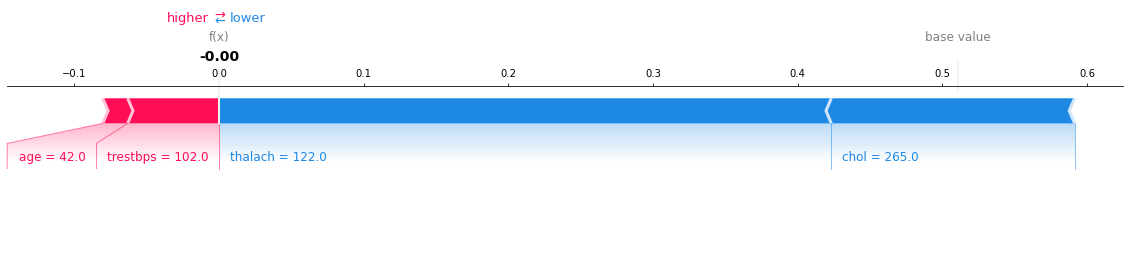

In [74]:
# Generate the SHAP force plot here for the 1st data on the holdout set
# this is the correct code for this case
shap.force_plot(explainer.expected_value, 
                shap_values[0], X_holdout.iloc[0], X_holdout.columns, matplotlib=True)

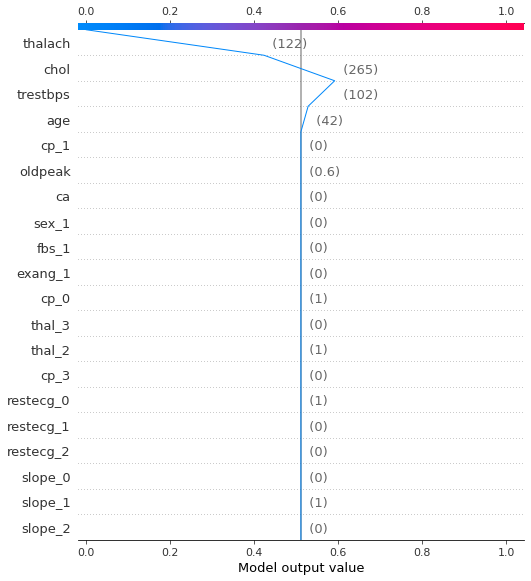

In [75]:
# get decision plot of the 1st data on the holdout set
shap.decision_plot(explainer.expected_value, shap_values[0], X_holdout.iloc[0])

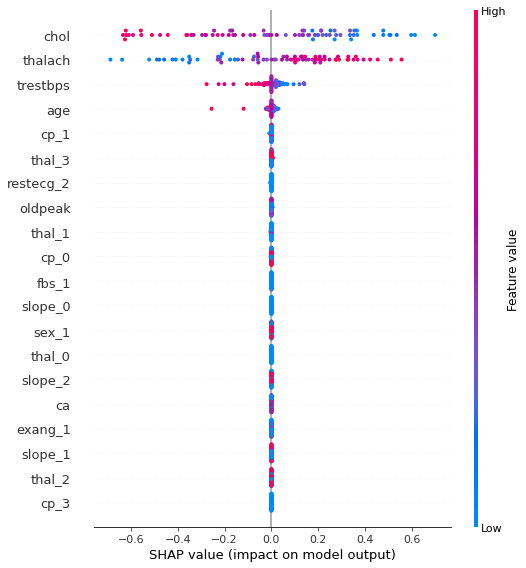

In [76]:
# get summary plot (bee swarm)
shap.summary_plot(shap_values, X_holdout)

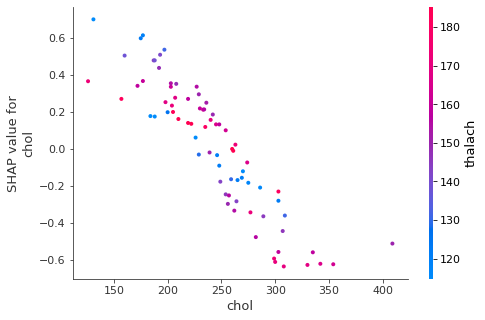

In [78]:
# partial dependence plot
shap.dependence_plot("chol", shap_values, X_holdout)

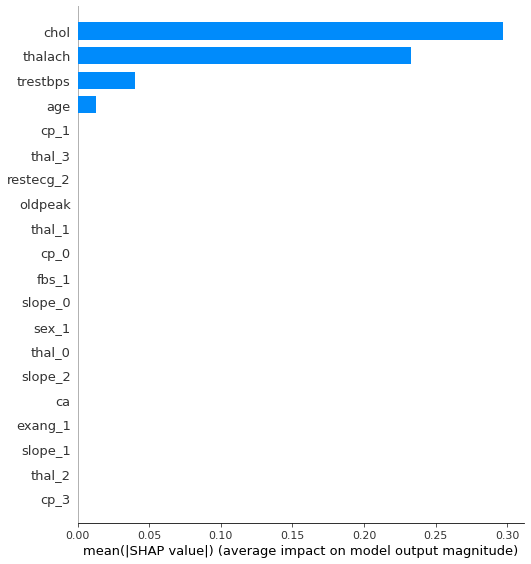

In [79]:
# get feature summary bar plot
shap.summary_plot(shap_values, features=X_holdout, feature_names=X_holdout.columns, plot_type='bar')

#### Sample for Tree Explainer

In [80]:
# for Tomek Links
# use RF as best model
# resample trainval first
tomek_links = TomekLinks()
X_trainval_resampled, y_trainval_resampled = tomek_links.fit_resample(X_trainval, y_trainval)

In [82]:
# train best model at hypertuned parameters
best_model = RandomForestClassifier(max_depth=9, n_estimators=400, random_state=11)
best_model.fit(X_trainval_resampled, y_trainval_resampled)

RandomForestClassifier(max_depth=9, n_estimators=400, random_state=11)

In [85]:
# define explainer here
# reference: https://shap-lrjball.readthedocs.io/en/latest/example_notebooks/kernel_explainer/Diabetes%20regression.html

explainer = shap.TreeExplainer(
    best_model, feature_names = X.columns)

In [87]:
# use shap_values = shap.sample(data, K) or
# shap_values = shap.kmeans(data, K) for faster runtimes
# refer to this example for explanation
# reference: https://shap-lrjball.readthedocs.io/en/latest/example_notebooks/kernel_explainer/Diabetes%20regression.html
shap_values = explainer.shap_values(X_holdout)

In [89]:
# example of shap_values with two arrays
shap_values

[array([[-0.02681446, -0.01021944,  0.01811777, ...,  0.00247555,
         -0.03903185, -0.03009249],
        [ 0.04241794,  0.0749448 , -0.01086049, ...,  0.00238823,
          0.05132749,  0.05509912],
        [-0.02611121,  0.00475758,  0.0182739 , ...,  0.00233781,
         -0.03621377, -0.0258056 ],
        ...,
        [ 0.02163373, -0.00588505,  0.03091829, ...,  0.00062679,
         -0.05336214, -0.03399874],
        [-0.01764146,  0.00948298, -0.02504831, ...,  0.00194751,
         -0.0284512 , -0.02697137],
        [-0.01520717,  0.00012446,  0.01777924, ...,  0.00132185,
         -0.03072558, -0.01893766]]),
 array([[ 0.02681446,  0.01021944, -0.01811777, ..., -0.00247555,
          0.03903185,  0.03009249],
        [-0.04241794, -0.0749448 ,  0.01086049, ..., -0.00238823,
         -0.05132749, -0.05509912],
        [ 0.02611121, -0.00475758, -0.0182739 , ..., -0.00233781,
          0.03621377,  0.0258056 ],
        ...,
        [-0.02163373,  0.00588505, -0.03091829, ..., -

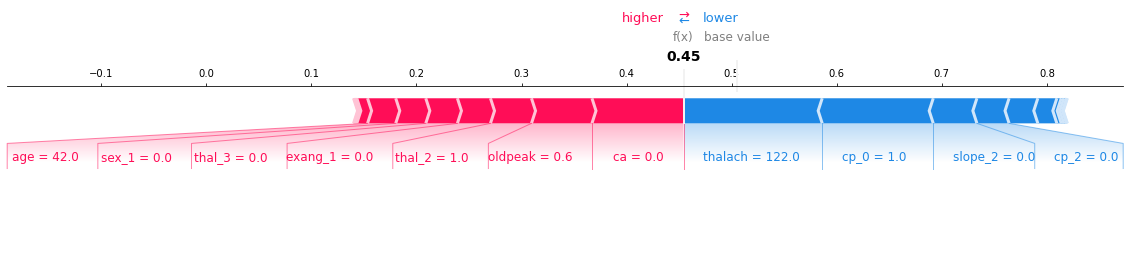

In [90]:
# Generate the SHAP force plot here
# for this error here, check whether your shap_values is a single or two arrays
# if your shap_values is a single array, there is no need to specify [1]
# the second bracket as in shap_values[1][0] pertains to the first shap value in the first array
# if your shap_values contains two arrays, specify only [1] in the expected_value argument
# (not [0] because this is for the negative class)
# for this example, the forceplot for the first patient in the holdout set is being looked into
shap.force_plot(explainer.expected_value[1], 
                shap_values[1][0], X_holdout.iloc[0], X_holdout.columns, matplotlib=True)

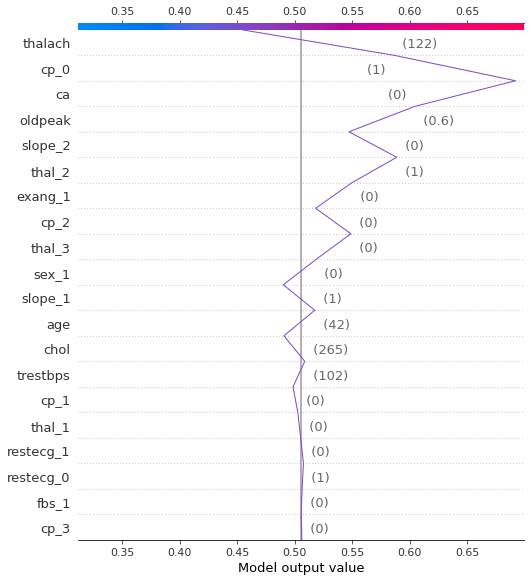

In [91]:
# get decision plot of the 1st data on the holdout set
shap.decision_plot(explainer.expected_value[1], shap_values[1][0], X_holdout.iloc[0])

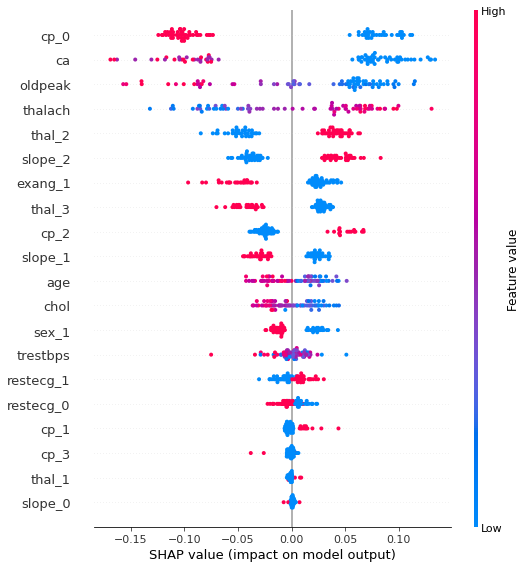

In [92]:
# get summary plot (bee swarm)
shap.summary_plot(shap_values[1], X_holdout)

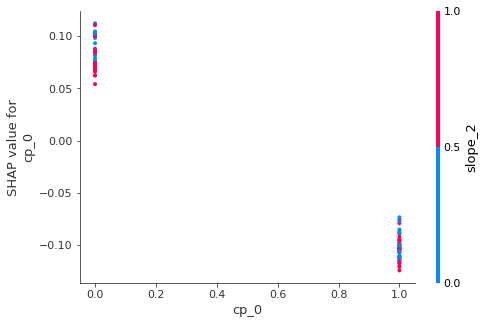

In [94]:
# partial dependence plot
shap.dependence_plot("cp_0", shap_values[1], X_holdout)

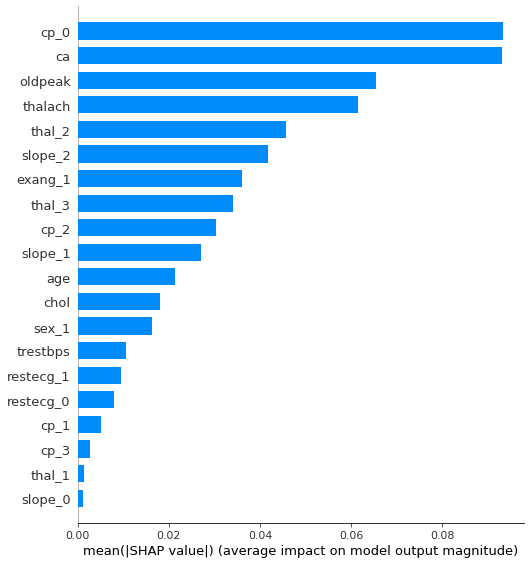

In [95]:
# get feature summary bar plot
shap.summary_plot(shap_values[1], features=X_holdout, feature_names=X_holdout.columns, plot_type='bar')

That's it! Hopefully this notebook would help you in the upcoming finals. God bless you! :)

- Psalm 121:1 -- I lift up my eyes to the mountains—where does my help come from?
- Psalm 121:2 -- My help comes from the Lord, the Maker of heaven and earth.